# Moment map tutorial for MIGHTEE-HI data

***
By Sambatriniaina H. A. Rajohnson,

Ph.D student at the University of Cape Town, South Africa.

with the helps of Wanga Mulaudzi.

Date: May 11, 2020 (created)
      July 3, 2020 (latest modification).
***

Welcome to the image analysis tutorial for MeerKAT spectral line data. After identifying HI sources in the cube and storing them into a file, we can start looking at the moment maps for each detection.

Moment maps are generated by taking various integrals over the velocity axis. By studying the emission channel by channel, the moment zero map is also referred to as the total HI map describing the overall gas distribution. It is proportional to the HI column density and represents the HI surface density. Moment one is representing the intensity-weighted velocity ﬁeld or the gas motion, and moment two the velocity dispersion.
![](./Picture_1.png)

This notebook will help you to generate moment 0 and moment 1 maps of the detections in your cube and export them into FITS files.

***
## 1- Inputs

In [32]:
detections_list = '/users/aycha/MIGHTEE/Analysis/1380/XMMLSS_12_1380_SHAR.dat' 
                     #Please input the path to your detection file list in an ASCII table format (e.g xxx.dat) with columns RA DEC FREQ
                     #Where ra, dec = 02h17m40.0s, 04d33m40.0s or in decimal coordinates 33.44444, 04.55555
                     #frequency in GHz. 
path_to_cube='/idia/users/aycha/pbcorrected/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.u.piwimed.pbcorr.u.e.fits'      
                     #Please input the path to the FITS cube

#Extraction parameters
subcube_width=2 #in arcmin

customize_cube_size = True #??? Do you want to customize your cube size, if not it will just take the subcube_width
width = [2,3,1.5,2,4,1.5,3,3]#width in arcmin for all the detections 


# A second option, we may encounter detections with bigger size, so you can select their index numbers, if they are just a few exception:
#index = [2]# for example in my detection, the detection with index 2 is bigger and should have a width of 4 arcminutes.
width_new=4 #4 arcmin instead of 2

velocity_convention='relativistic' #you can also change to 'optical' but it is better to take the relativistic velocity convention
#half_freq_width=1e-3        #it is better to select a small frequency range for making moment maps, with this a 2MHz subcube will be extracted
chans = 4 #Number of channels to be extracted before and after the central frequency

#Beam convolution parameters

circular_beam_axis = 20 # 20'' x 20''

#Moment maps parameters
sigma=3                #Masking
mean_profile_width=300 #km/s, needed for moment 1 map
dirName = 'Moment_maps_1380' #Path of the Directory for moment maps to be created

## 2-Modules and initialization

In [2]:
from astropy.io import ascii
from astropy import constants as const
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy import units as u
import Distance_package #a python file for calculating Distance in a cosmological manner
import matplotlib.offsetbox
from matplotlib.offsetbox import (
    AnchoredText, AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker)
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import os #for creating directories
import pylab as pl
import scipy as sp
import shutil
import spectral_cube
from spectral_cube.cube_utils import Beam
from spectral_cube import SpectralCube
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
#Capture all Warnings
    

pl.rc('axes',titlesize='large')
pl.rc('text', usetex=False)
pl.rc('font', **{'family':'serif','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'

## 3-Detection extraction and Noise estimation

Subcubes containing all the detections will be extracted in the main cube. They will be defined as the signal cubes, having a certain width w in arcminutes (depending on the detection size). Since the noise is varying locally in the cube, it is needed to know the noise next in the region right to the signal cube but not containing any emission. This will be defined as noise cube, a cube of the exact same size as the signal cube which will be used to estimate the local rms for each detection. 

![](./Picture_2.png)

In [3]:
def get_subcube_and_noisecube(cube, ra, dec, freq, velocity_convention='radio', width_in_arcmin = 0.5*u.arcmin, width='30arcsec', chans=1):
    '''
    RA, DEC, FREQ will be taken from the detections_table
    freq in GHz.
    width of 30arcsec 
    frequency width of dfreq of 500KHz
    This are the default values but can be changed when calling the function
    '''
    
    df = cube.header['CDELT3']*(u.Hz).to(u.GHz) 
    
    #frequency ranges with the number of channels to be extracted
    freq_lower = '%.5fGHz' % (freq-chans*df) 
    freq_upper = '%.5fGHz' % (freq+chans*df)
    
    if isinstance(detections[0]['ra'], np.float64): #if decimal
        crtf_str = 'centerbox[['+str(ra)+','+str(dec)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    else:
        crtf_str = 'centerbox[['+ra+','+dec+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    #extracting a squared cube with a certain width at the ra and dec position at a specific frequency range
    #crtf_str = 'circle[['+ra+','+dec+'], '+width+'], coord=fk5, range=['+freq_lower+', '+freq_upper+']]' #for a circle
    # fk5 is just another frame like icrs
    
    #RA and DEC into degree if not yet decimal
    coord = SkyCoord(ra*u.deg, dec*u.deg, frame='fk5')
    ra_deg = coord.ra.deg + width_in_arcmin.to(u.deg).value
    dec_deg = coord.dec.deg # same declination

    noise_crtf = 'centerbox[['+str(ra_deg)+','+str(dec_deg)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    # Noise cube extraction

    target_subcube = cube.subcube_from_crtfregion(crtf_str)
    target_subcube = target_subcube[1:] #the first channel usually has a very big beam, so we will remove it
    #generating the new signal cube from the crtf region, spectral axis = frequency
    noise_subcube = cube.subcube_from_crtfregion(noise_crtf)
    noise_subcube = noise_subcube[1:]
    
    #CONVOLVING TO A COMMON BEAM:
    common_beam=target_subcube.beams.common_beam(tolerance=1e-5) #the first channel usually has a very big beam
    
    try:
        target_subcube = target_subcube.convolve_to(common_beam)
        noise_subcube = noise_subcube.convolve_to(common_beam)
    except: #if the beam cannot be convolved
        print('Cannot be convolved into a common beam')
        target_subcube = target_subcube
        noise_subcube = noise_subcube
    
    #generating the corresponding noise cube from the crtf region, spectral axis = frequency
    freqs = target_subcube.spectral_axis #The frequency units is in Hertz
    
    #RMS CALCULATION IN THE NOISE CUBE
    x = noise_subcube.std(axis=(1,2))/noise_subcube.unit #getting the std for each channel
    mean_rms = np.mean(x) #std then mean std
    
    #Converting the cube spectral axis into velocity km/s in radio or optical convention
    #the signal cubes will be chosen depending on the observer
    vel_subcube = target_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    noise_velsubcube = noise_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    
    #Storing the velocity axis value separately from the cube so that we can use later
    vel = vel_subcube.spectral_axis
    
    #flux density values in Jy/beam
    target_spectrum_sum = target_subcube.sum(axis=(1,2))/target_subcube.unit
    
    
    # The outputs will be:
    # the signal cube with spectral axis frequency
    # the signal cube with spectral axis velocity
    # the frequency axis
    # the velocity axis
    # the flux density
    # the noise cube with spectral axis velocity
    return target_subcube, vel_subcube, freqs, vel, target_spectrum_sum,noise_velsubcube,mean_rms

## 4- Moment maps

Steps for making moment maps:
* **Convolve your cube into a common restoring beam:** the bigger the restored beam is, the more sensitive to faint emission we will be. For that, we will convolve the signal cubes into 3 different beams for spatial smoothing:
    * a common restoring beam (different for each detection),
    * a beam 50% bigger than the common restoring beam. Since this one will be different for each detection, we will need to create a common beam for all the detection. The bigger the better.
    * a circular common beam for all the detections: bmaj=bmin, bpa = 0 deg. Let's say for example $20'' \times~20''$ as default, but you can change it.
* **Convolve your noise cubes into the same restoring beam**
* **Measure mean noise in the noise cubes**
* **Calculate the scale bar for each detection**: in the moment map, we need to know the scale of the HI emission. The map is in pixels, and we know that for our imaging for example 1 pixel = 2 arcsec, so by knowing the distance of the galaxy by assuming a small angle, we will know the size of 10 pixels in parsecs.

In [4]:
def beam_convolution_and_mean_rms(cube,noise_cube,beam,detections_list):
    '''
    Cube to be convolved
    Detections list
    '''
    convolved_cube = []
    convolved_noise_cube = []
    mean_rms = []
    # Loop through each detections
    for i in range(len(detections_list)):
        
        convolved_cube.append(cube[i].convolve_to(beam))
        convolved_noise_cube.append(noise_cube[i].convolve_to(beam))
        x = convolved_noise_cube[i].std(axis=(1,2))/convolved_noise_cube[i].unit #getting the std for each channel
        mean_rms.append(np.mean(x.value)) #std then mean std
    '''
    mean_rms = mean of the standard deviation of the flux in each channel
    '''
    return convolved_cube, mean_rms

#Knowing the scale bar
#Redshift calculations
def calc_z(nu):
    '''
    nu is the observed frequency in GHz
    '''
    nu_0 = 1.42040575 # Rest frequency
    return (nu_0 - nu)/nu

#Scale bar calculation: conversion from arcsec to pc: Pixels in arcsec into pc
def angle_to_pc(x_arcsec,distance_Mpc):
    D = x_arcsec*(u.arcsec.to(u.rad))*distance_Mpc
    return D.to(u.kpc)

#Scale bar calculation for 10 kpc size, how many pixels?
#Scale bar calculation: conversion from arcsec to pc:
def pc_to_pixel(pixel_size, parsec_size,distance_Mpc):
    Npix = parsec_size.to(u.Mpc)/(pixel_size*(u.arcsec.to(u.rad))*distance_Mpc)
    return Npix.value

### Plotting scale bar and PSF in the moment image:

In [5]:
#Making a scale bar for the data

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=2.5, extent = 0.00, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.8, ppad = 0, sep=2, prop=None, 
                 frameon=True, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **kwargs)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **kwargs)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **kwargs)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon)
        
#Making PSF:
class AnchoredEllipse(AnchoredOffsetbox):
    def __init__(self, transform, width, height, angle, loc,
                 pad=0.1, borderpad=0.1, prop=None, frameon=True):
        """
        Draw an ellipse the size in data coordinate of the give axes.

        pad, borderpad in fraction of the legend font size (or prop)
        """
        self._box = AuxTransformBox(transform)
        self.ellipse = Ellipse((0, 0), width, height, angle,edgecolor='k', fc='None')
        self._box.add_artist(self.ellipse)
        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon)


def draw_ellipse(ax,width,height,angle,frameon=True):
    """
    Draw an ellipse of width=0.1, height=0.15 in data coordinates
    """
    ae = AnchoredEllipse(ax.transData, width=width, height=height, angle=angle,
                         loc='lower left', pad=0.5, borderpad=0.4,
                         frameon=frameon)

    ax.add_artist(ae)

### Moment maps generation

In [44]:
def scale_factor(cube):
    '''
    Factor needed for converting Jy/beam into Jy
    '''
    FWHM = np.pi/(4*np.log(2))
    dpix = cube.header['CDELT2']*3600
    bmaj = cube.beam.major.value
    bmin = cube.beam.minor.value
    beam_area = FWHM*bmaj*bmin
    scale_factor = dpix**2/beam_area
    return scale_factor

def moment_fits(cube, mask, rms, dirName='', folder2='', name='', sigma = 3, get_fits=False):
    '''
    Generating the moment maps into FITS files
    No need to multiply to dv anymore if the cubes are already in velocity axis
    No need to multiply by the scale factor, this is only needed for HI mass calculations not for column density
    '''
    #Masking the cube
    masked_cube = cube.with_mask(mask > sigma*rms*mask.unit)
    
    #Moment 0 and 1 of the masked cubes
    moment0 = masked_cube.moment(order=0) #take the moment 0 of the masked cube, in Jy/beam km/s
    moment1 = masked_cube.moment(order=1) #in km/s
    
    #moment_0=np.nan_to_num(moment0) #nan to zeros needed in the fits format but fine in the calculation
    #moment_1=np.nan_to_num(moment1)
    
    
    #Moment maps into FITS Files
    if get_fits == True:
        if not os.path.exists(dirName):
            os.makedirs(dirName)
            print("Directory " , dirName ,  " Created ")
            if not os.path.exists(dirName+'/'+folder2):
                os.makedirs(dirName+'/'+folder2)
        else:    
            print("Directory " , dirName ,  " already exists")
            #shutil.rmtree(dirName)
            #os.makedirs(dirName)
            if not os.path.exists(dirName+'/'+folder2):
                os.makedirs(dirName+'/'+folder2)
            else:
                print("Directory"+dirName+'/'+folder2+"already exists")
                #shutil.rmtree(dirName+'/'+folder2)
                #os.makedirs(dirName+'/'+folder2)
        moment0.write(dirName+'/'+folder2+'/'+name+'_0.fits',overwrite=True) #moment 0 into fits file with unit Jy km/s
        moment1.write(dirName+'/'+folder2+'/'+name+'_1.fits',overwrite=True)
    
    return moment0.value, moment1.value

In [7]:
#Normalizing the colormap, needed especially for moment 1, but not obligatory
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

In [8]:
def moment_0(mom0_data, vmax, beam, scale_bar, ax, RA, DEC, FREQ, title='moment 0',put_colorbar=True):
    '''
    Plotting the moment 0 map
    '''
    mom0_data = np.ma.masked_where(mom0_data == 0, mom0_data)
    cmap = cm.jet #Colormap choice
    cmap.set_bad('white') # Background color ax.set_facecolor('xkcd:white')
    
    
    #Display the moment map image
    im = ax.imshow(mom0_data, cmap=cmap, vmin=0, vmax=vmax)
    
    #Contour levels
    contours = ax.contour(mom0_data, levels=8, colors='k',linewidths=1)
    
    #Scalebar
    ob = AnchoredHScaleBar(size=scale_bar, label='10 kpc', loc=1, frameon=False,
                           pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)
    
    #Beam
    draw_ellipse(ax,beam.major.to(u.arcsec).value,beam.minor.to(u.arcsec).value,-beam.pa.to(u.deg).value,
                        frameon=False)
    #Put colorbar
    if put_colorbar == True:
        cbar = plt.colorbar(im,fraction=0.046, pad=0.,ax=ax)
        cbar.ax.set_ylabel(r'Integrated flux (Jy km s$^{-1}$)')
        
    #Detections details
    anchored_text = AnchoredText('RA='+RA+',\n'+'DEC = '+DEC+',\nFREQ= '+FREQ+' GHz',
                                     loc=2, borderpad=0.5,frameon=False, 
                             prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
    ax.add_artist(anchored_text)
    
    #Axis details
    ax.invert_yaxis()
    ax.set_title(title,fontsize=25)
    ax.set_xlabel("Right Ascension (J2000)", fontsize=20)
    ax.set_ylabel("Declination (J2000)", fontsize=20)
    ax.tick_params(which='major', length=7, width=1, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    return contours

def moment_1(mom1_data, beam, scale_bar, ax, RA, DEC, FREQ, title='moment 1',put_colorbar=True):
    '''
    Plotting the moment 1 map
    '''
    cmap = cm.jet #Colormap choice
    cmap.set_bad('white') # Background color ax.set_facecolor('xkcd:white')
    
    vmin = np.nanmin(mom1_data)
    vmax = np.nanmax(mom1_data)
    midpoint = (vmin+vmax)/2
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)
    
    #Display the moment map image
    im = ax.imshow(mom1_data, cmap=cmap)
    
    #Contour levels
    contours = ax.contour(mom1_data, levels=8, colors='k',linewidths=1)
    
    #Scalebar
    ob = AnchoredHScaleBar(size=scale_bar, label='10 kpc', loc=1, frameon=False,
                           pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)
    
    #Beam
    draw_ellipse(ax,beam.major.to(u.arcsec).value,beam.minor.to(u.arcsec).value,-beam.pa.to(u.deg).value,
                        frameon=False)
    #Put colorbar
    if put_colorbar == True:
        cbar = plt.colorbar(im,fraction=0.046, pad=0.,ax=ax)
        cbar.ax.set_ylabel(r'Velocity (km s$^{-1}$)')
        
    #Detections details
    anchored_text = AnchoredText('RA='+RA+',\n'+'DEC = '+DEC+',\nFREQ= '+FREQ+' GHz',
                                     loc=2, borderpad=0.5,frameon=False, 
                             prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
    ax.add_artist(anchored_text)
    
    #Axis details
    ax.invert_yaxis()
    ax.set_title(title,fontsize=25)
    ax.set_xlabel("Right Ascension (J2000)", fontsize=20)
    ax.set_ylabel("Declination (J2000)", fontsize=20)
    ax.tick_params(which='major', length=7, width=1, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

In [9]:
def moment_0(mom0_data, vmax, beam, scale_bar, ax, RA, DEC, FREQ, title='moment 0',put_colorbar=True):
    '''
    Plotting the moment 0 map
    '''
    cmap = cm.jet #Colormap choice
    cmap.set_bad('white') # Background color ax.set_facecolor('xkcd:white')
    
    #Display the moment map image
    im = ax.imshow(mom0_data, cmap=cmap, vmin=0, vmax=vmax)
    
    #Contour levels
    contours = ax.contour(mom0_data, levels=8, colors='k',linewidths=1)
    
    #Scalebar
    ob = AnchoredHScaleBar(size=scale_bar, label='10 kpc', loc=1, frameon=False,
                           pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)
    
    #Beam
    draw_ellipse(ax,beam.major.to(u.arcsec).value,beam.minor.to(u.arcsec).value,-beam.pa.to(u.deg).value,
                        frameon=False)
    #Put colorbar
    if put_colorbar == True:
        cbar = plt.colorbar(im,fraction=0.046, pad=0.,ax=ax)
        cbar.ax.set_ylabel(r'Integrated flux (Jy km s$^{-1}$)')
        
    #Detections details
    anchored_text = AnchoredText('RA='+RA+',\n'+'DEC = '+DEC+',\nFREQ= '+FREQ+' GHz',
                                     loc=2, borderpad=0.5,frameon=False, 
                             prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
    ax.add_artist(anchored_text)
    
    #Axis details
    ax.invert_yaxis()
    ax.set_title(title,fontsize=25)
    ax.set_xlabel("Right Ascension (J2000)", fontsize=20)
    ax.set_ylabel("Declination (J2000)", fontsize=20)
    ax.tick_params(which='major', length=7, width=1, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    return contours

In [10]:
def moment_1(mom1_data, beam, scale_bar, ax, RA, DEC, FREQ, title='moment 1',put_colorbar=True):
    '''
    Plotting the moment 1 map
    '''
    cmap = cm.jet #Colormap choice
    cmap.set_bad('white') # Background color ax.set_facecolor('xkcd:white')
    
    vmin = np.nanmin(mom1_data)
    vmax = np.nanmax(mom1_data)
    midpoint = (vmin+vmax)/2
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)
    
    #Display the moment map image
    im = ax.imshow(mom1_data, cmap=cmap, norm=norm)
    
    #Contour levels
    contours = ax.contour(mom1_data, levels=8, colors='k',linewidths=1)
    
    #Scalebar
    ob = AnchoredHScaleBar(size=scale_bar, label='10 kpc', loc=1, frameon=False,
                           pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)
    
    #Beam
    draw_ellipse(ax,beam.major.to(u.arcsec).value,beam.minor.to(u.arcsec).value,-beam.pa.to(u.deg).value,
                        frameon=False)
    #Put colorbar
    if put_colorbar == True:
        cbar = plt.colorbar(im,fraction=0.046, pad=0.,ax=ax)
        cbar.ax.set_ylabel(r'Velocity (km s$^{-1}$)')
        
    #Detections details
    anchored_text = AnchoredText('RA='+RA+',\n'+'DEC = '+DEC+',\nFREQ= '+FREQ+' GHz',
                                     loc=2, borderpad=0.5,frameon=False, 
                             prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
    ax.add_artist(anchored_text)
    
    #Axis details
    ax.invert_yaxis()
    ax.set_title(title,fontsize=25)
    ax.set_xlabel("Right Ascension (J2000)", fontsize=20)
    ax.set_ylabel("Declination (J2000)", fontsize=20)
    ax.tick_params(which='major', length=7, width=1, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

## 5-Let's run!

In [11]:
%%capture 
#Capture all Warnings
detections = ascii.read(detections_list)
cube = SpectralCube.read(path_to_cube)
pixel_size= cube.header['CDELT2']*3600


# Subcube and noise cubes extractions
tsum = [] #sum value of the flux
vel = [] # velocity
vel_subcube = [] #subcube with velocity axis
noise_velsubcube = []
mean_rms_common = []

for i in range(len(detections)):
    ra = detections[i]['ra'] #taking the RA column
    dec = detections[i]['dec'] #taking the DEC column
    freq = detections[i]['freq'] #taking the FREQ column
    if customize_cube_size == False:
        if i in index:
            a, b, c, d, e, f, g = get_subcube_and_noisecube(cube, ra, dec, freq,width_in_arcmin = width_new*u.arcmin, 
                                                         width=str(width_new)+'arcmin', chans=chans)
        else:
            a, b, c, d, e, f, g = get_subcube_and_noisecube(cube, ra, dec, freq,width_in_arcmin = subcube_width*u.arcmin, 
                                                         width=str(subcube_width)+'arcmin', chans=chans)
    else:
        if i ==5: #for the companion only, but normally all the detections are the same
             a, b, c, d, e, f, g = get_subcube_and_noisecube(cube, ra, dec, freq,width_in_arcmin = width[i]*u.arcmin, 
                                                         width=str(width[i])+'arcmin', chans=10)
        else:
            a, b, c, d, e, f, g = get_subcube_and_noisecube(cube, ra, dec, freq,width_in_arcmin = width[i]*u.arcmin, 
                                                         width=str(width[i])+'arcmin', chans=chans)
    tsum.append(e)
    vel.append(d) 
    vel_subcube.append(b)
    noise_velsubcube.append(f)
    mean_rms_common.append(g)

#redshift into distance
z = []
for i in range(len(detections)):
    z.append(calc_z(detections[i]['freq']))
    
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)    
d = Distance_package.Distance(z=z,cosmology=cosmo)

#scale bar for 10 pixels
scale = []
for i in range(len(detections)):
    scale.append(angle_to_pc(10*pixel_size,d[i])) #10 pixels scale
    
#scale bar for 10 kpc
bar_10_kpc = []
for i in range(len(detections)):
    bar_10_kpc.append(pc_to_pixel(pixel_size, 10*u.kpc,d[i]))

### PSFs 

In [12]:
bmaj = vel_subcube[0].beam.major
bmin = vel_subcube[0].beam.minor
bpa = vel_subcube[0].beam.pa
common_beam = Beam(major=bmaj, minor=bmin, pa=bpa) #just for beam plot

In [13]:
circular_beam = Beam(major=circular_beam_axis*u.arcsec, minor=circular_beam_axis*u.arcsec, 
                   pa=0*u.deg)
smoothed_cube, mean_rms_circ = beam_convolution_and_mean_rms(vel_subcube, noise_velsubcube, circular_beam, detections)

### 5.1 - Getting the output moment maps separately in a directory

I think the mom 0 maps depends on the number of channel we are selecting when making the moment maps, if we only select the indexes where the detection is, then we have a good pattern of the moment 0.

#### The following lines are only needed if we need special cut for specific detections
e.g: the detection 6 is actually a companion for detection 5, so if we take all the channels, it will also add into the mom 0 map the flux values for the main galaxy. However, if we only take a very few channels, it will not give a good estimation of the noise in the noisecubes.

What we can do is therefore, select by looking at the channel maps, the indices where the emission starts and end. So that we are only summing the emission out, but we have a good estimation of the noise. This is only needed for detection 6 but is also applicable to the other detections.

#### 5.1.1 Channel maps of the emission

we can take note of the velocity range where the emission starts and end, put that in an ascii file and name the column as `v_a` and `v_b`.

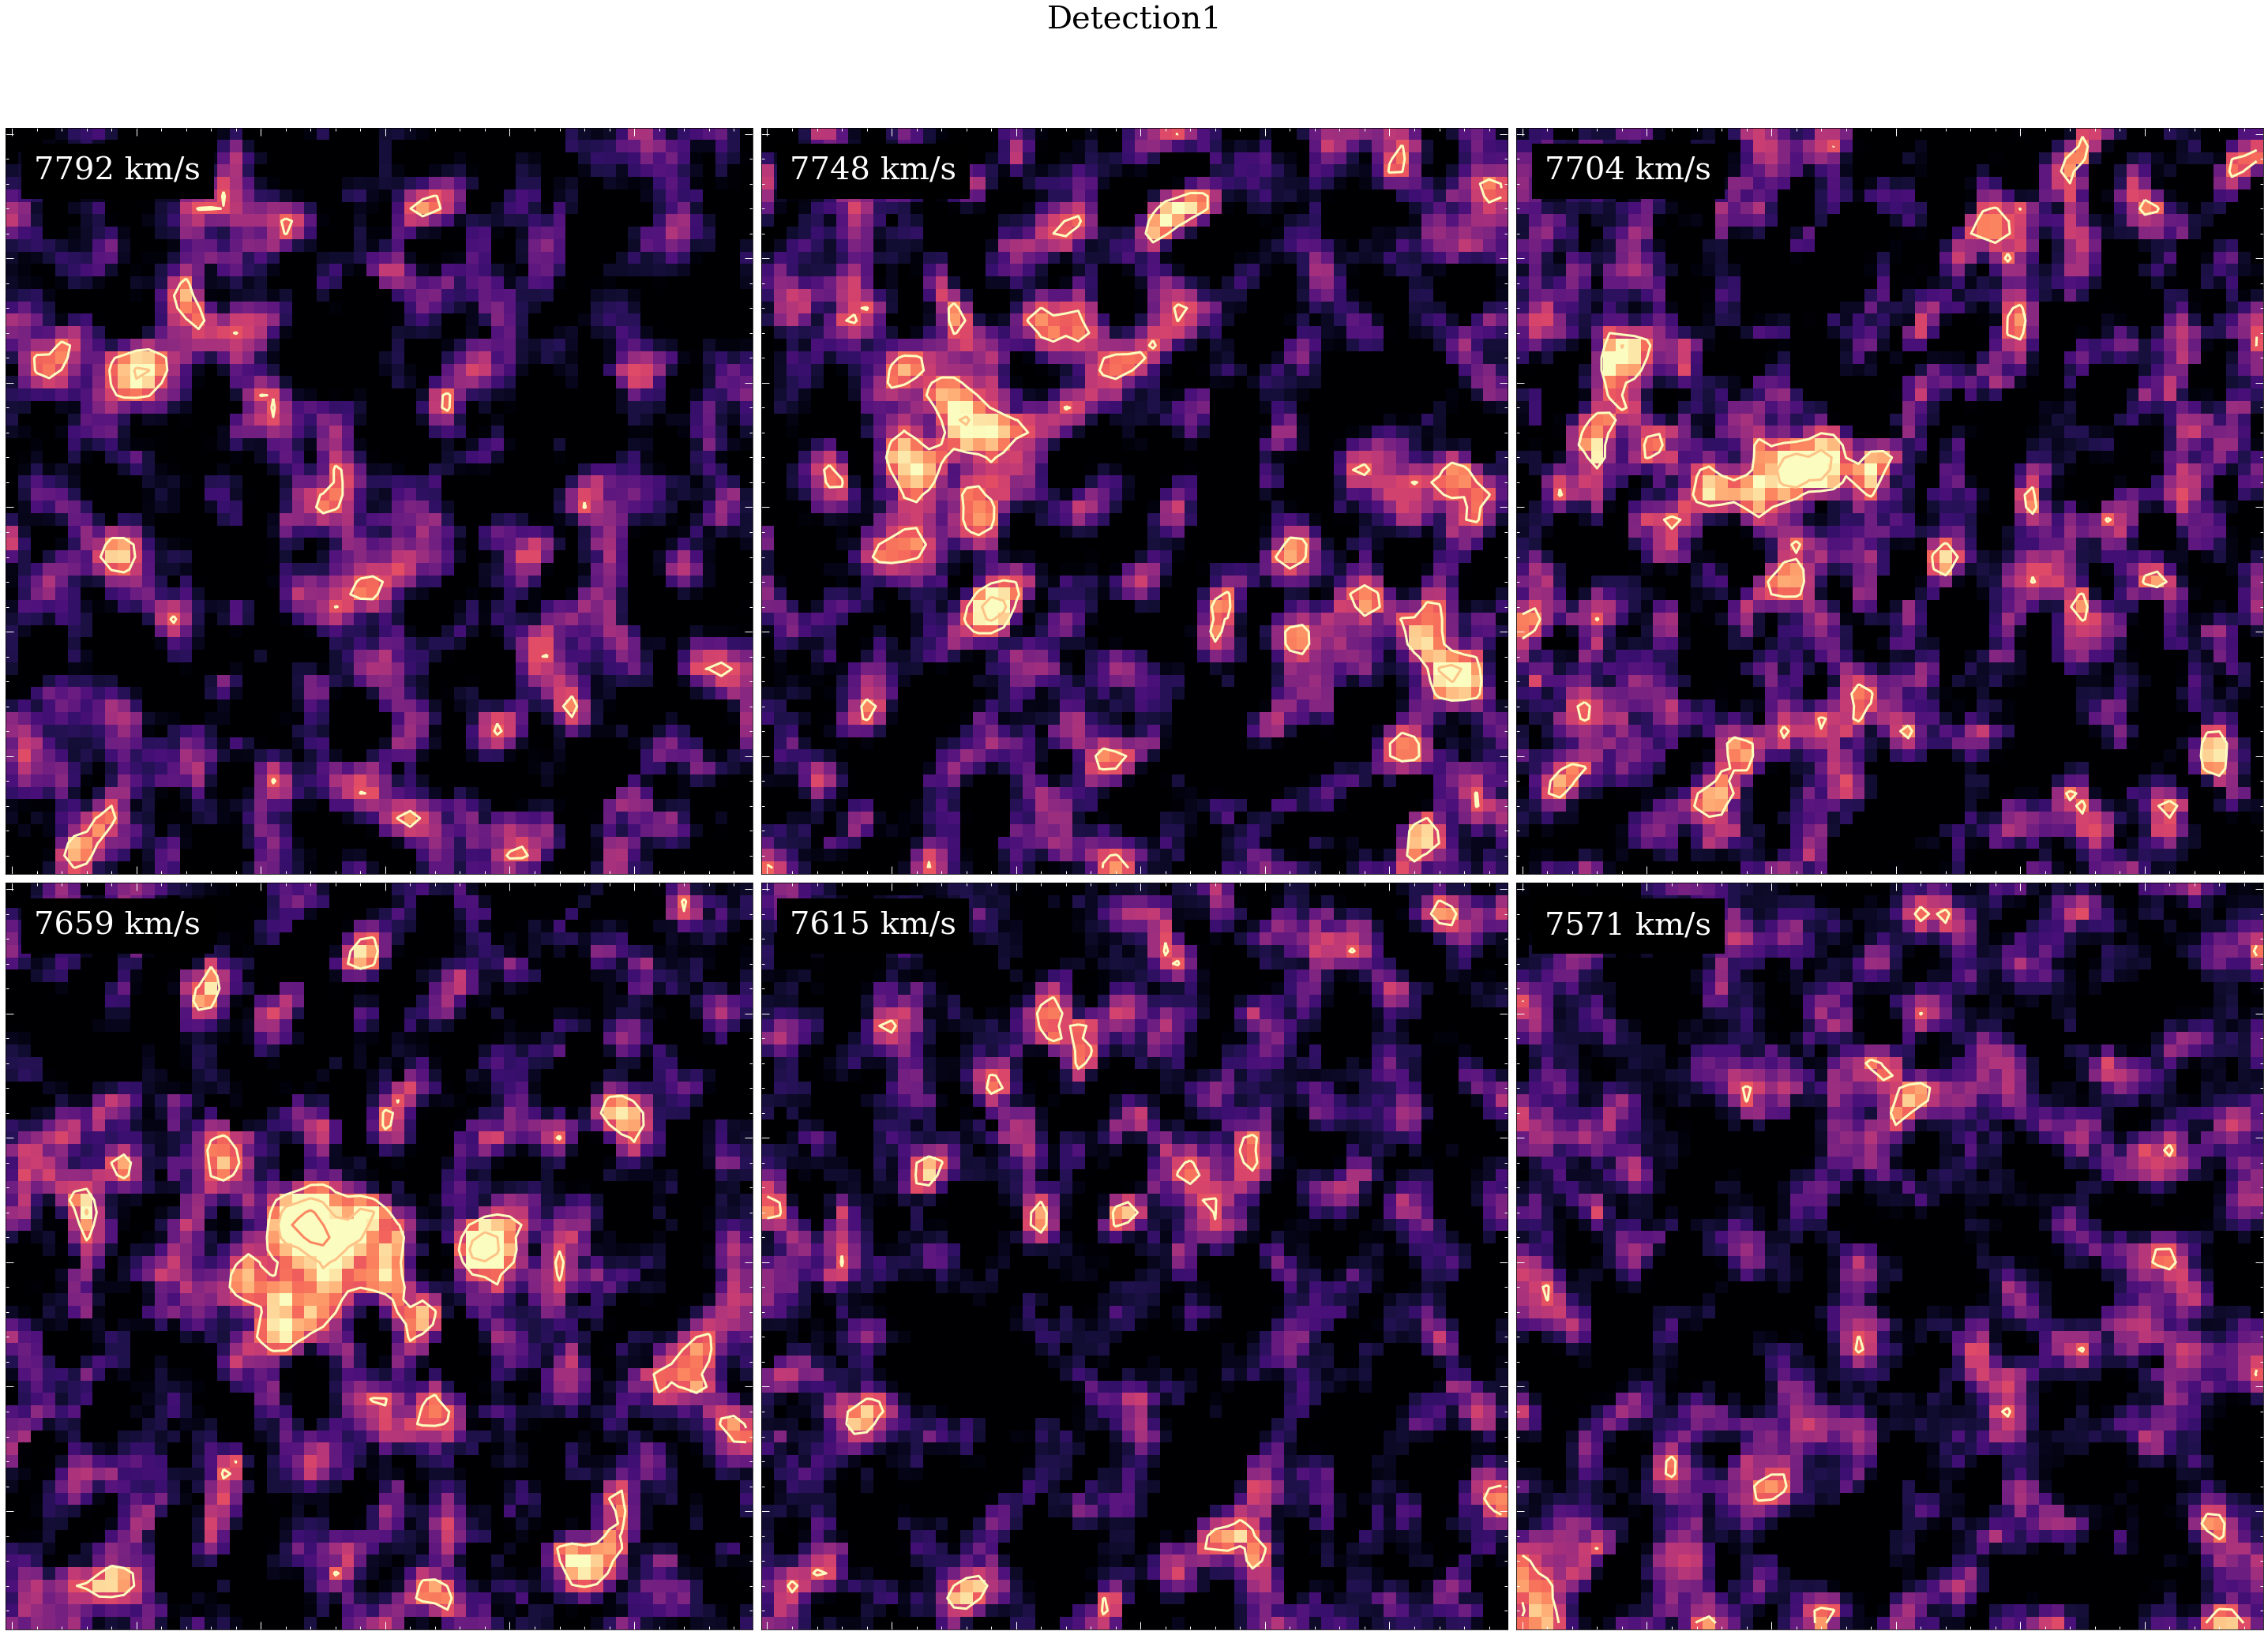

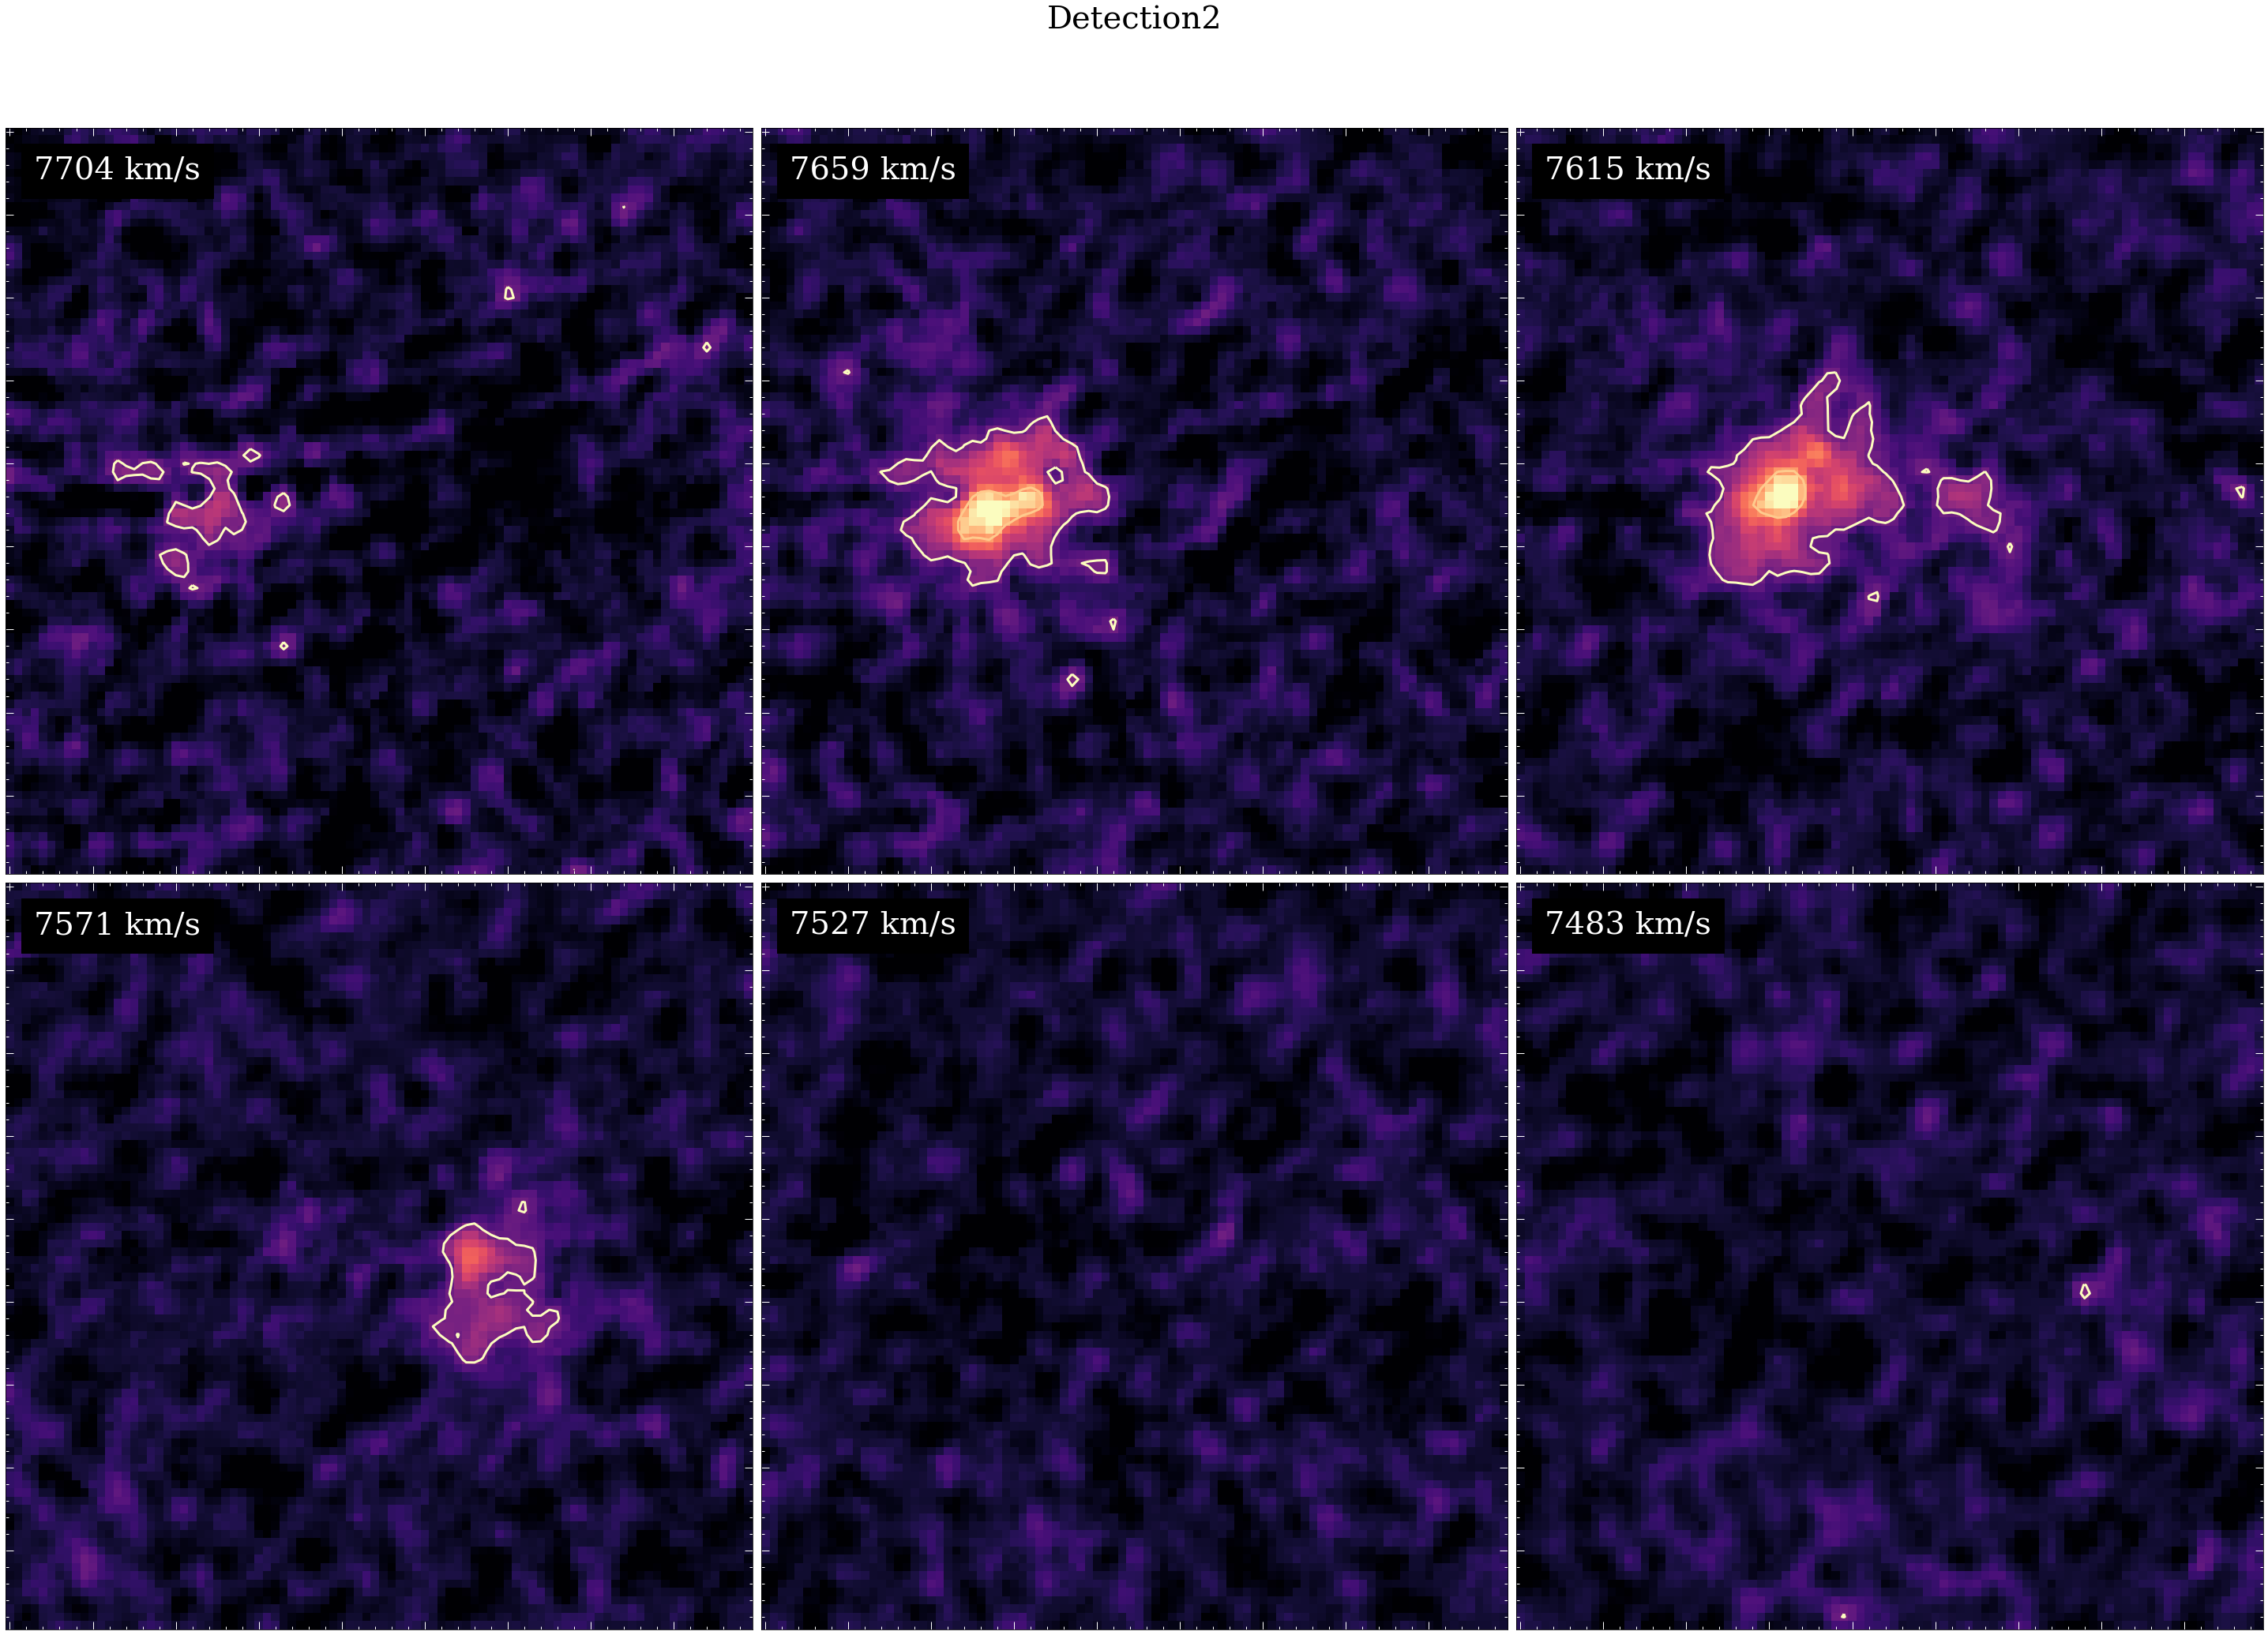

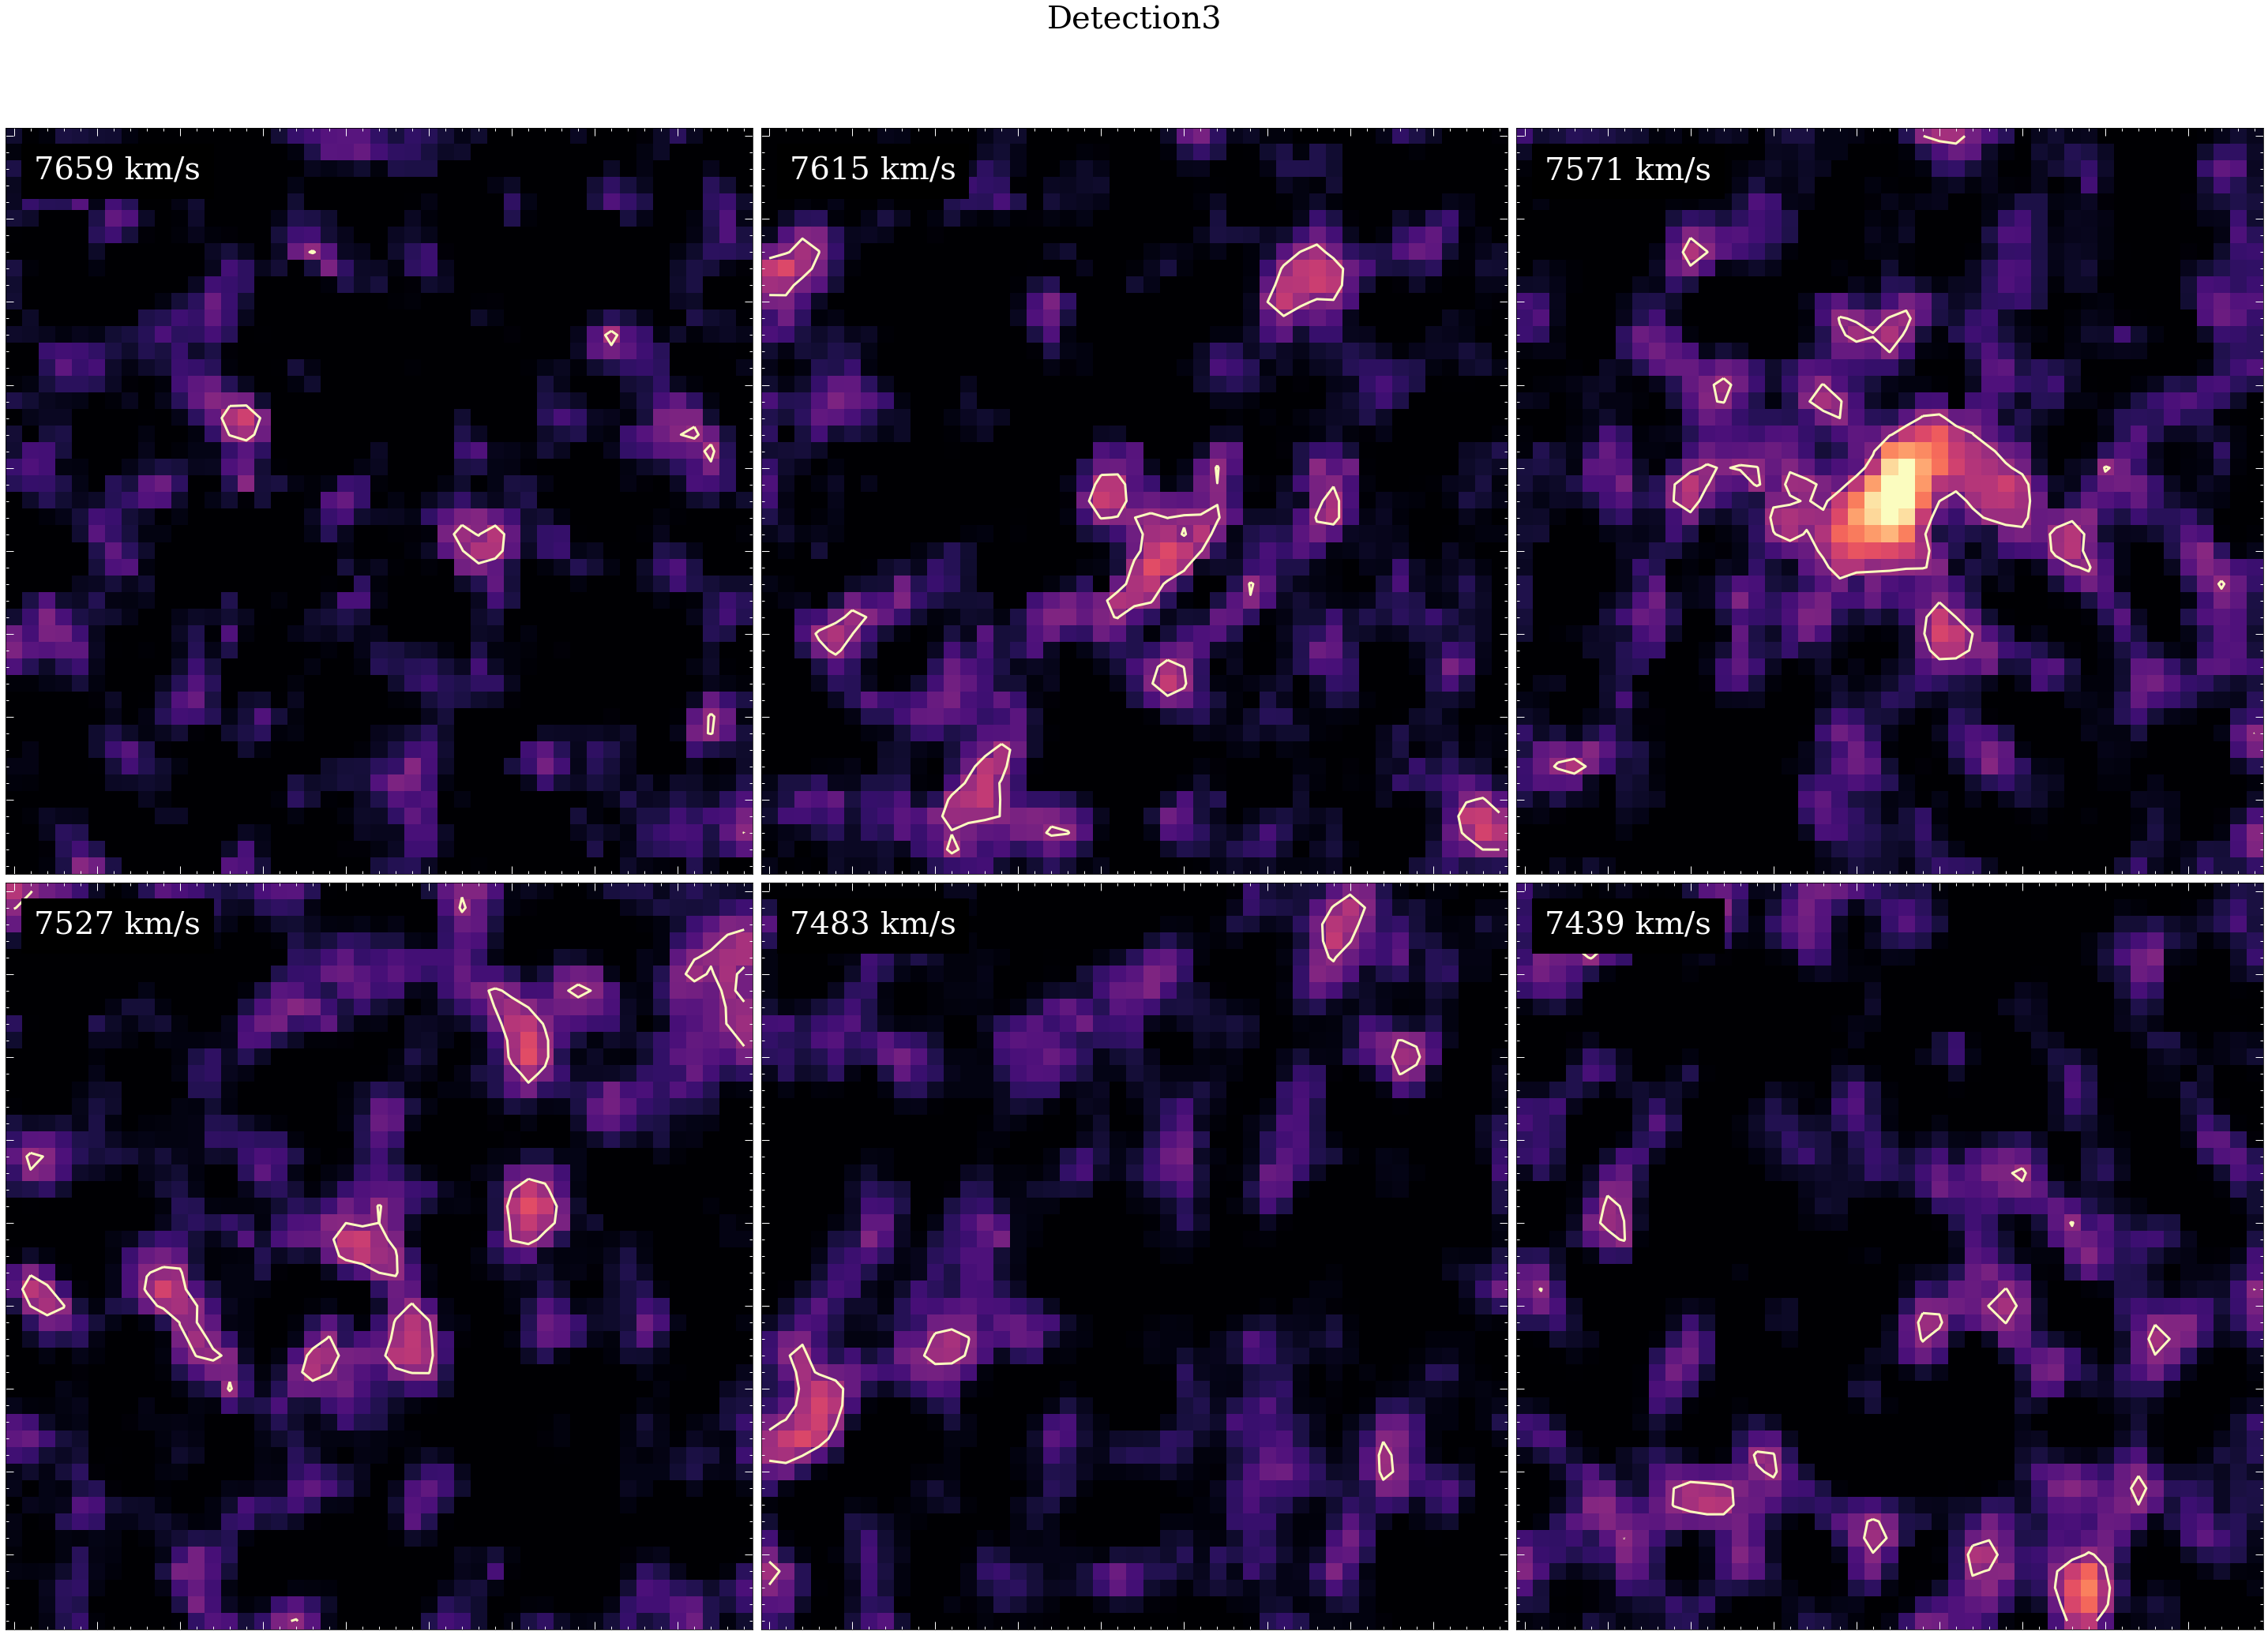

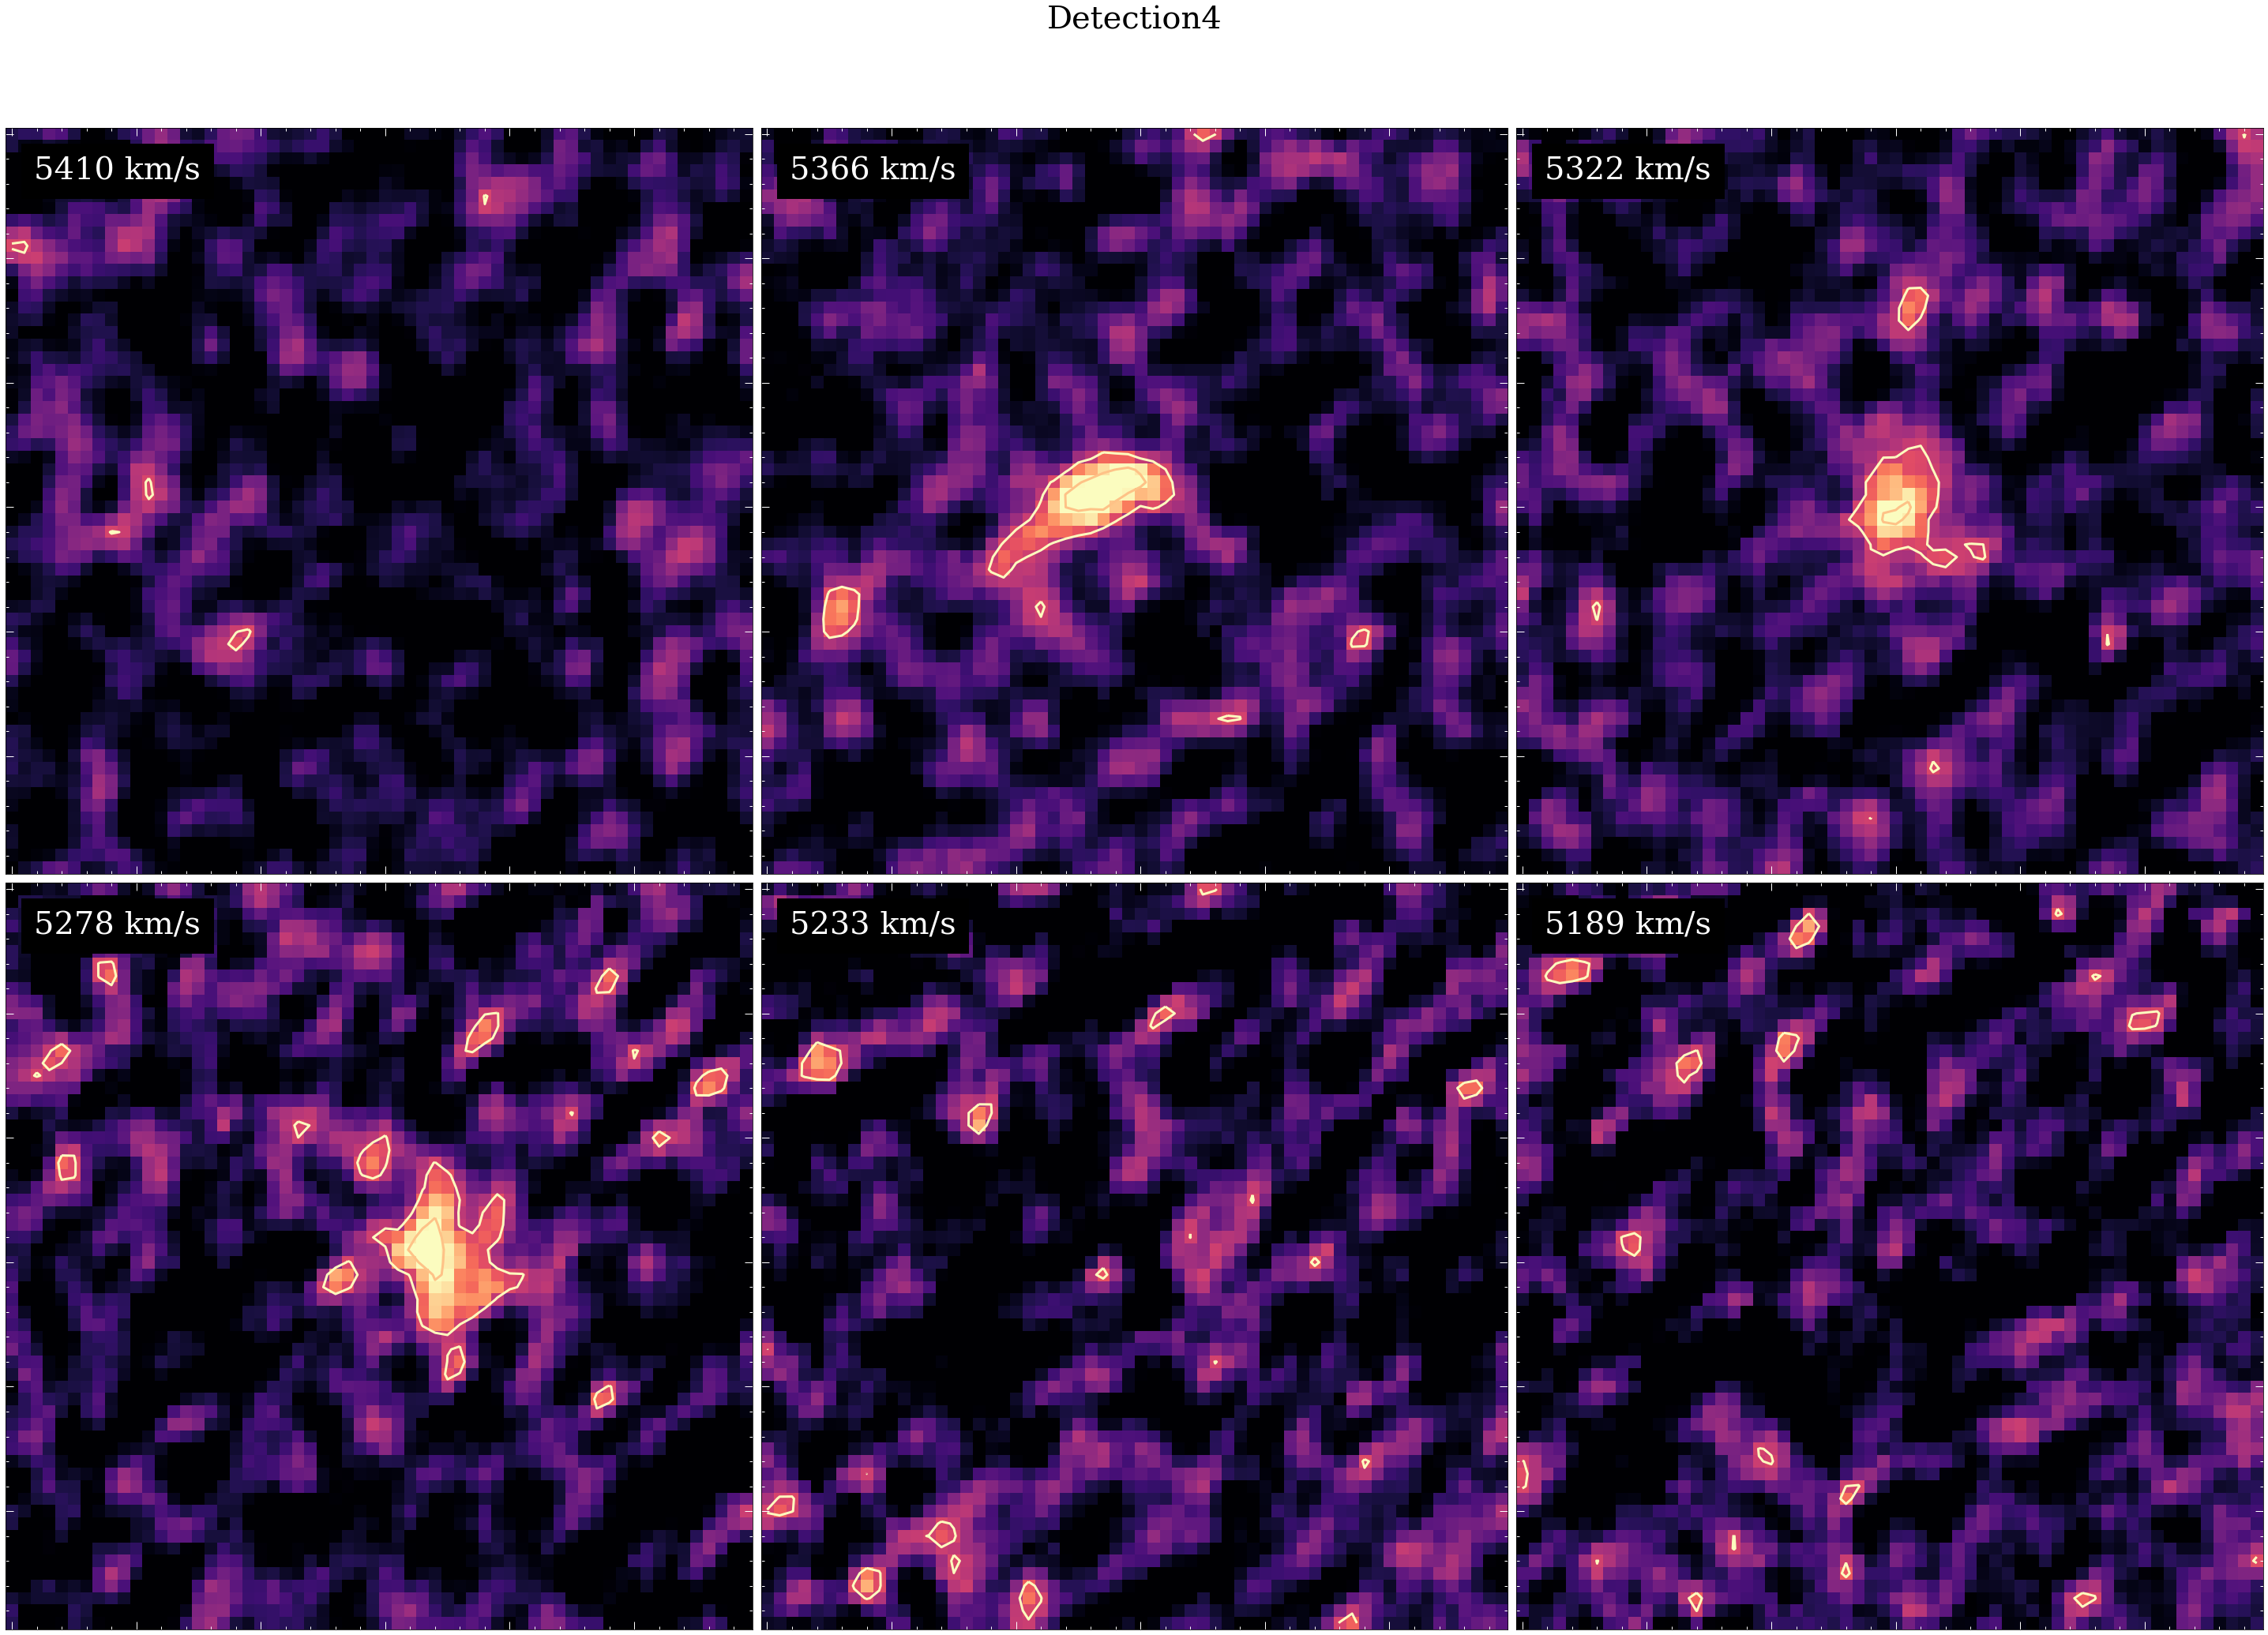

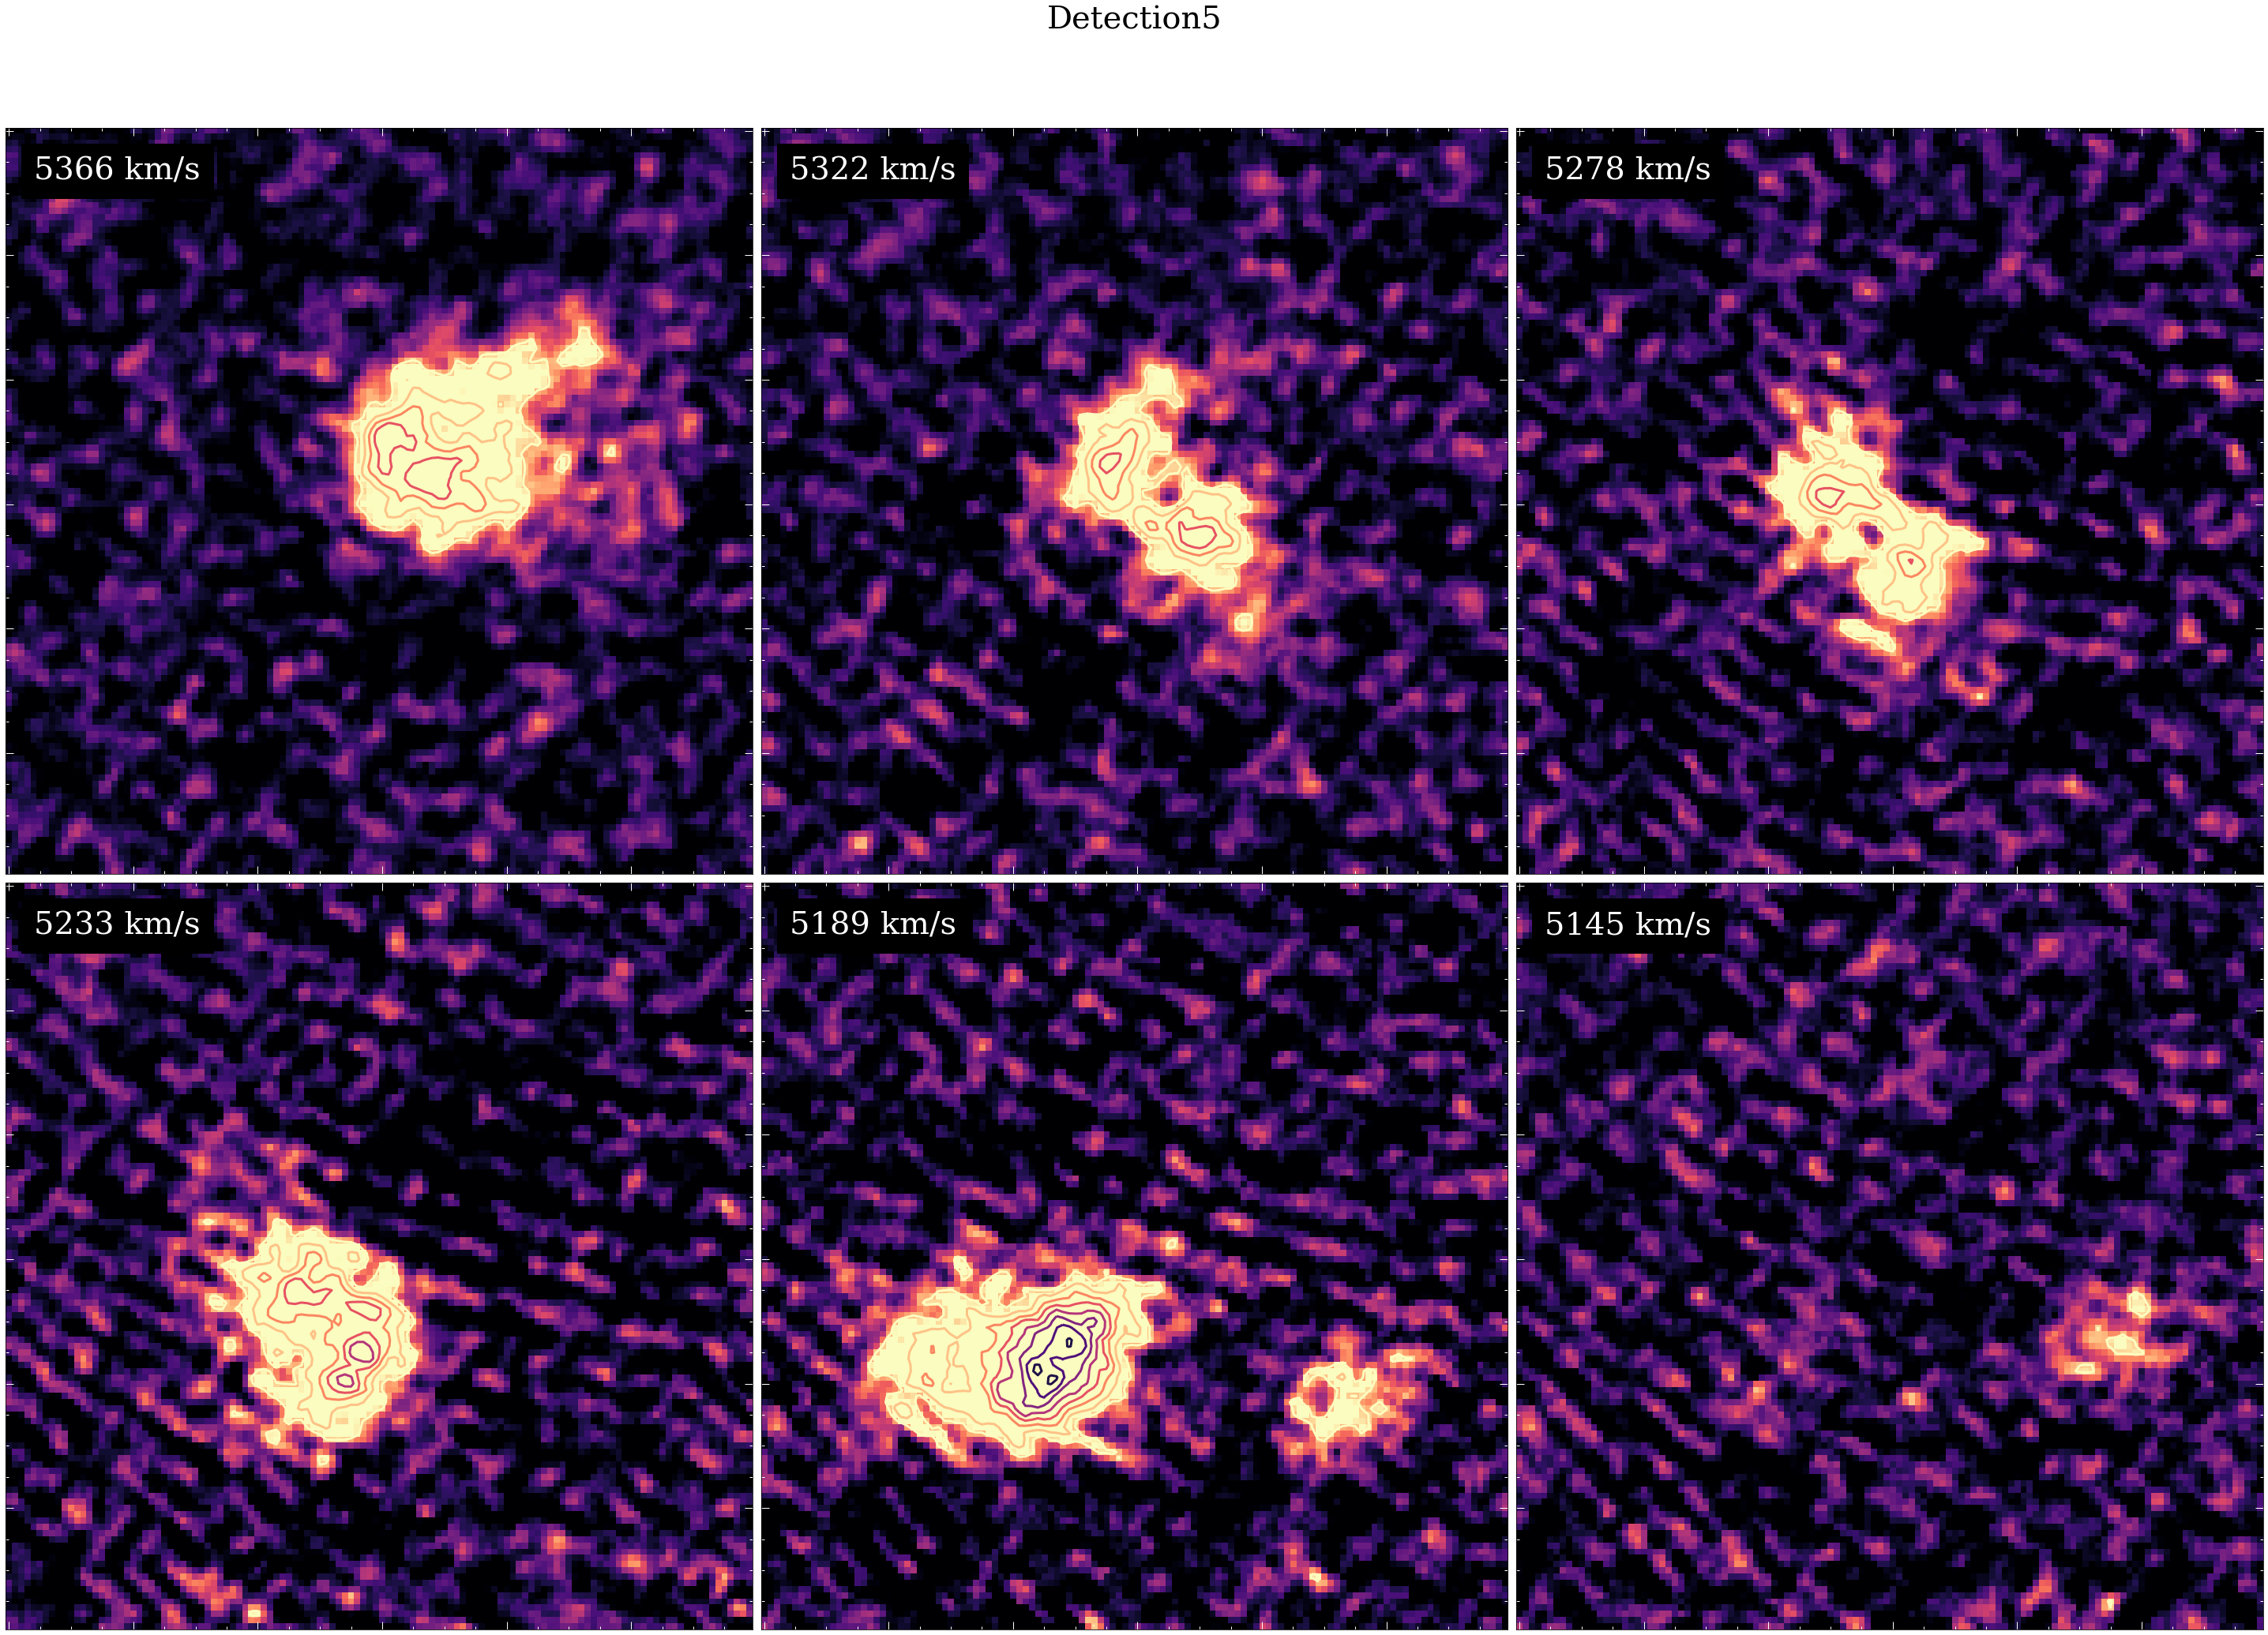

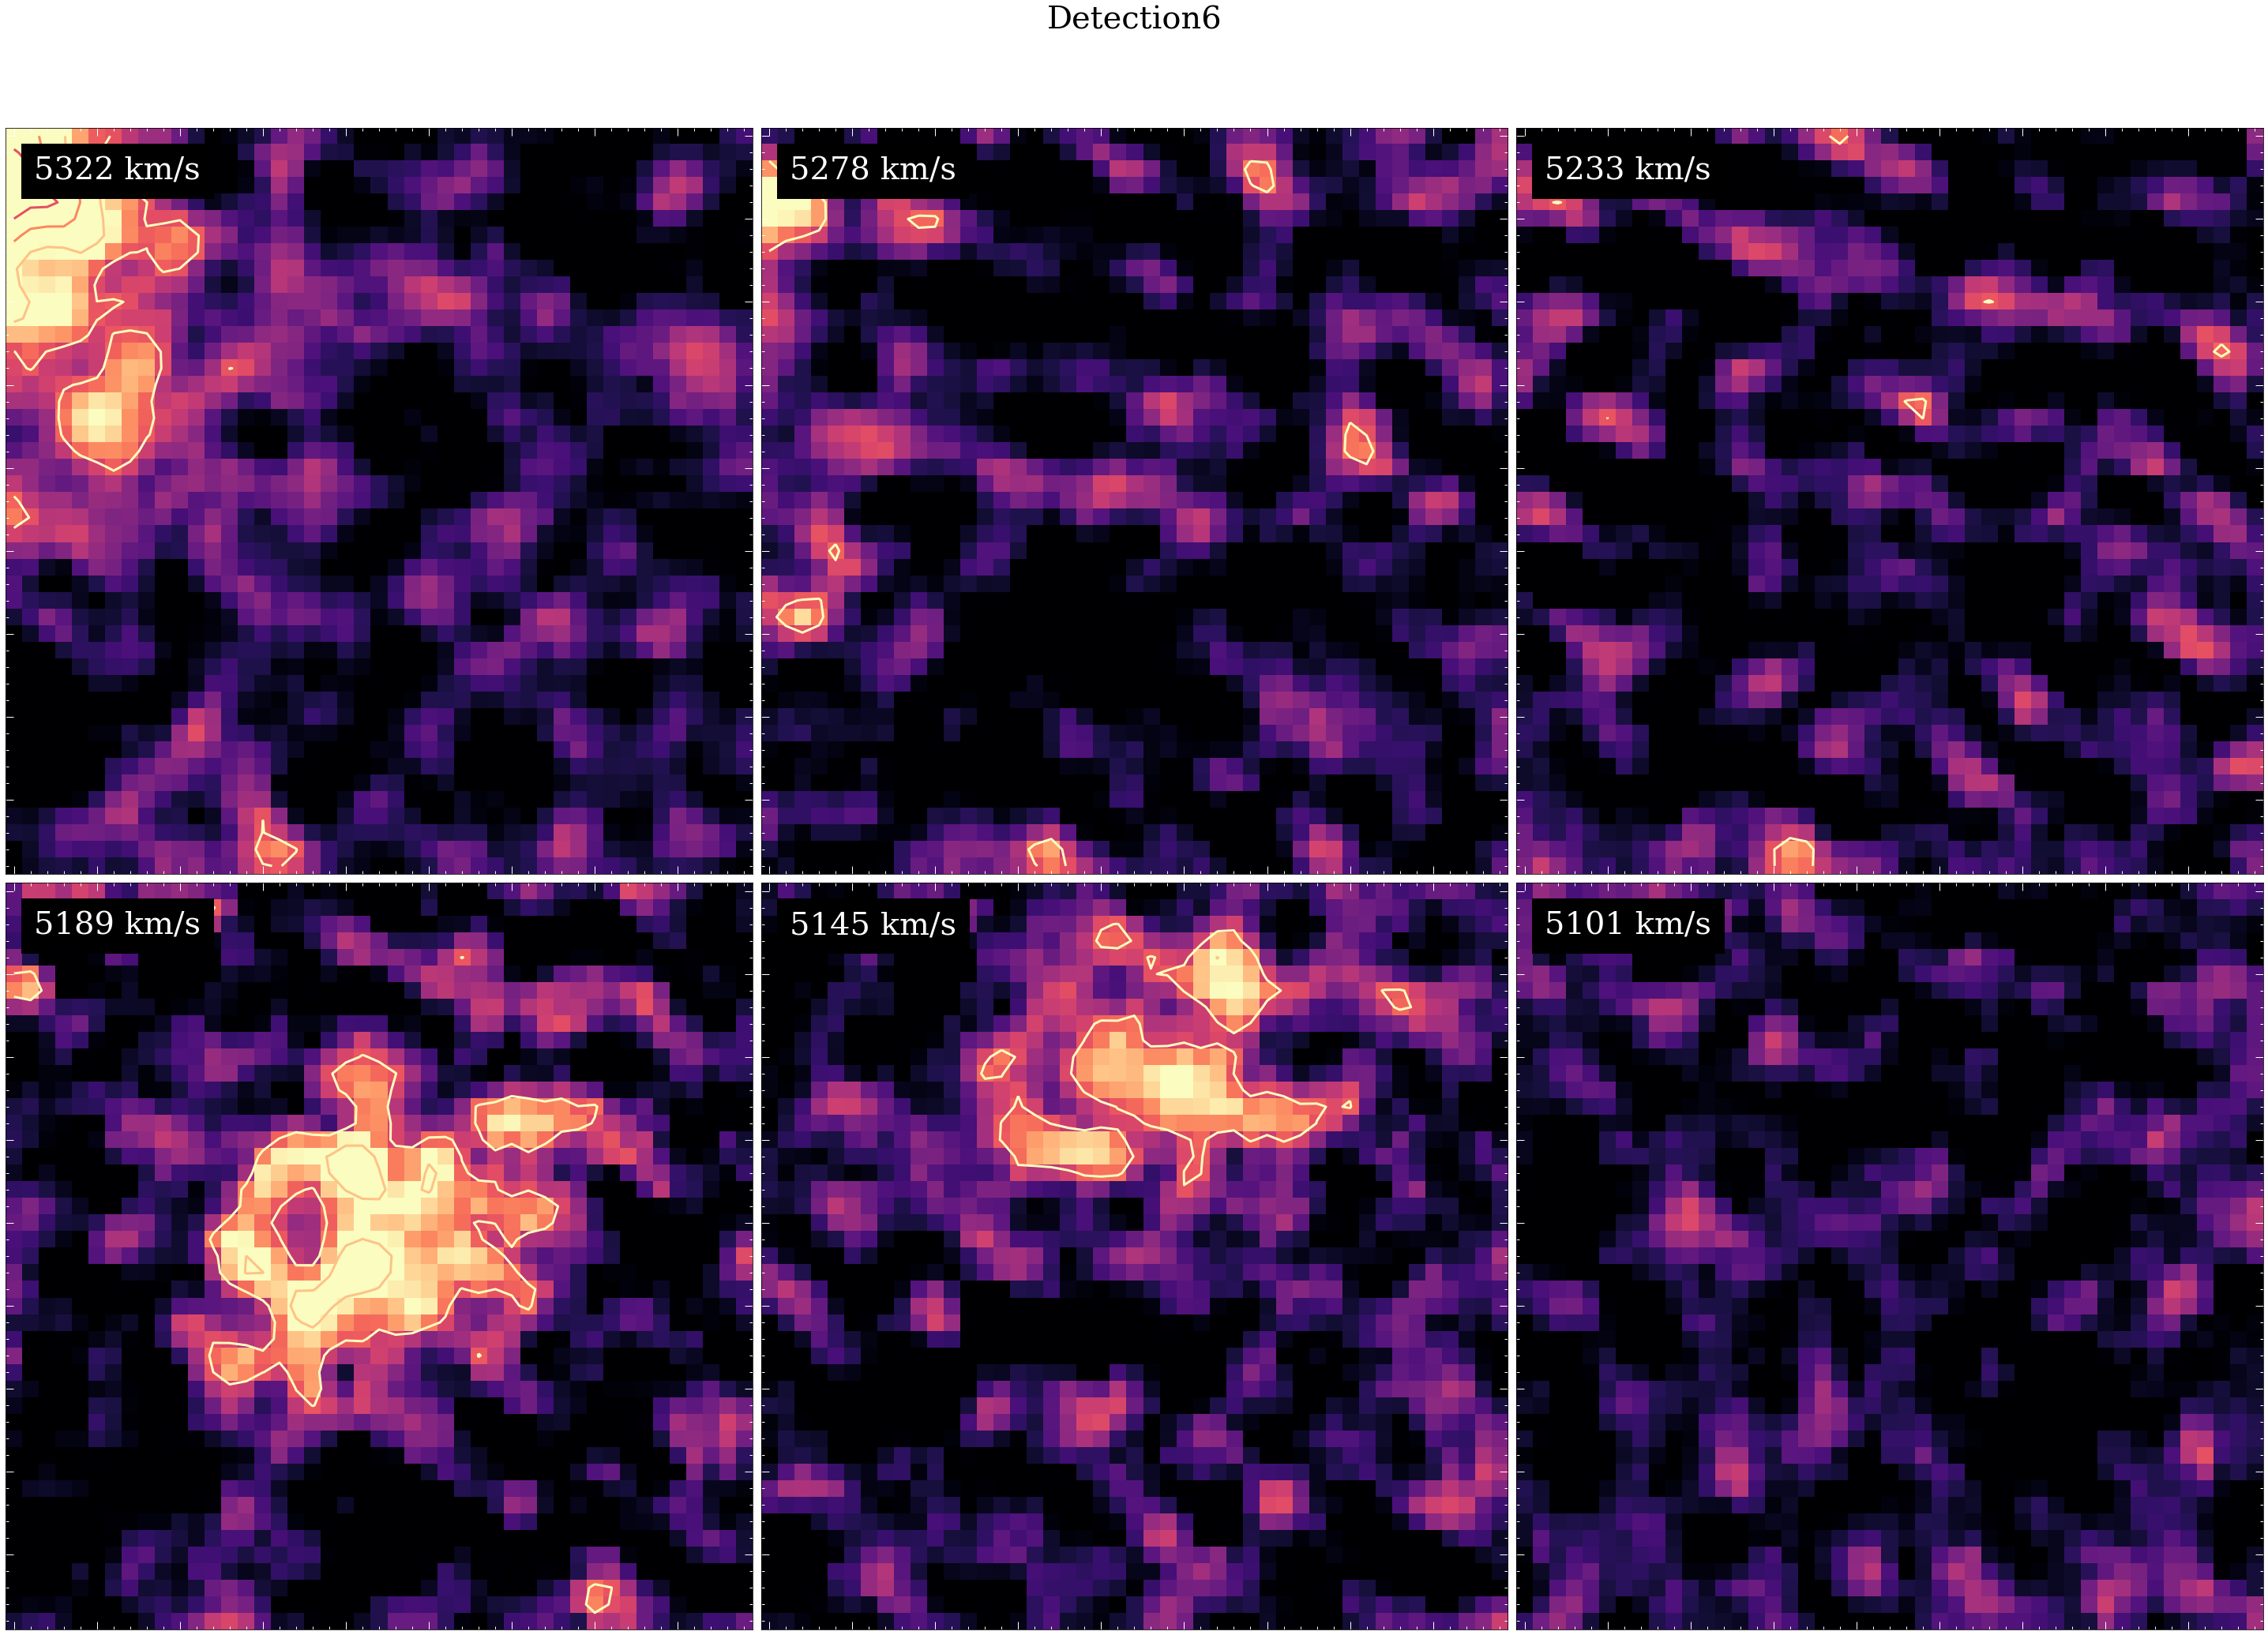

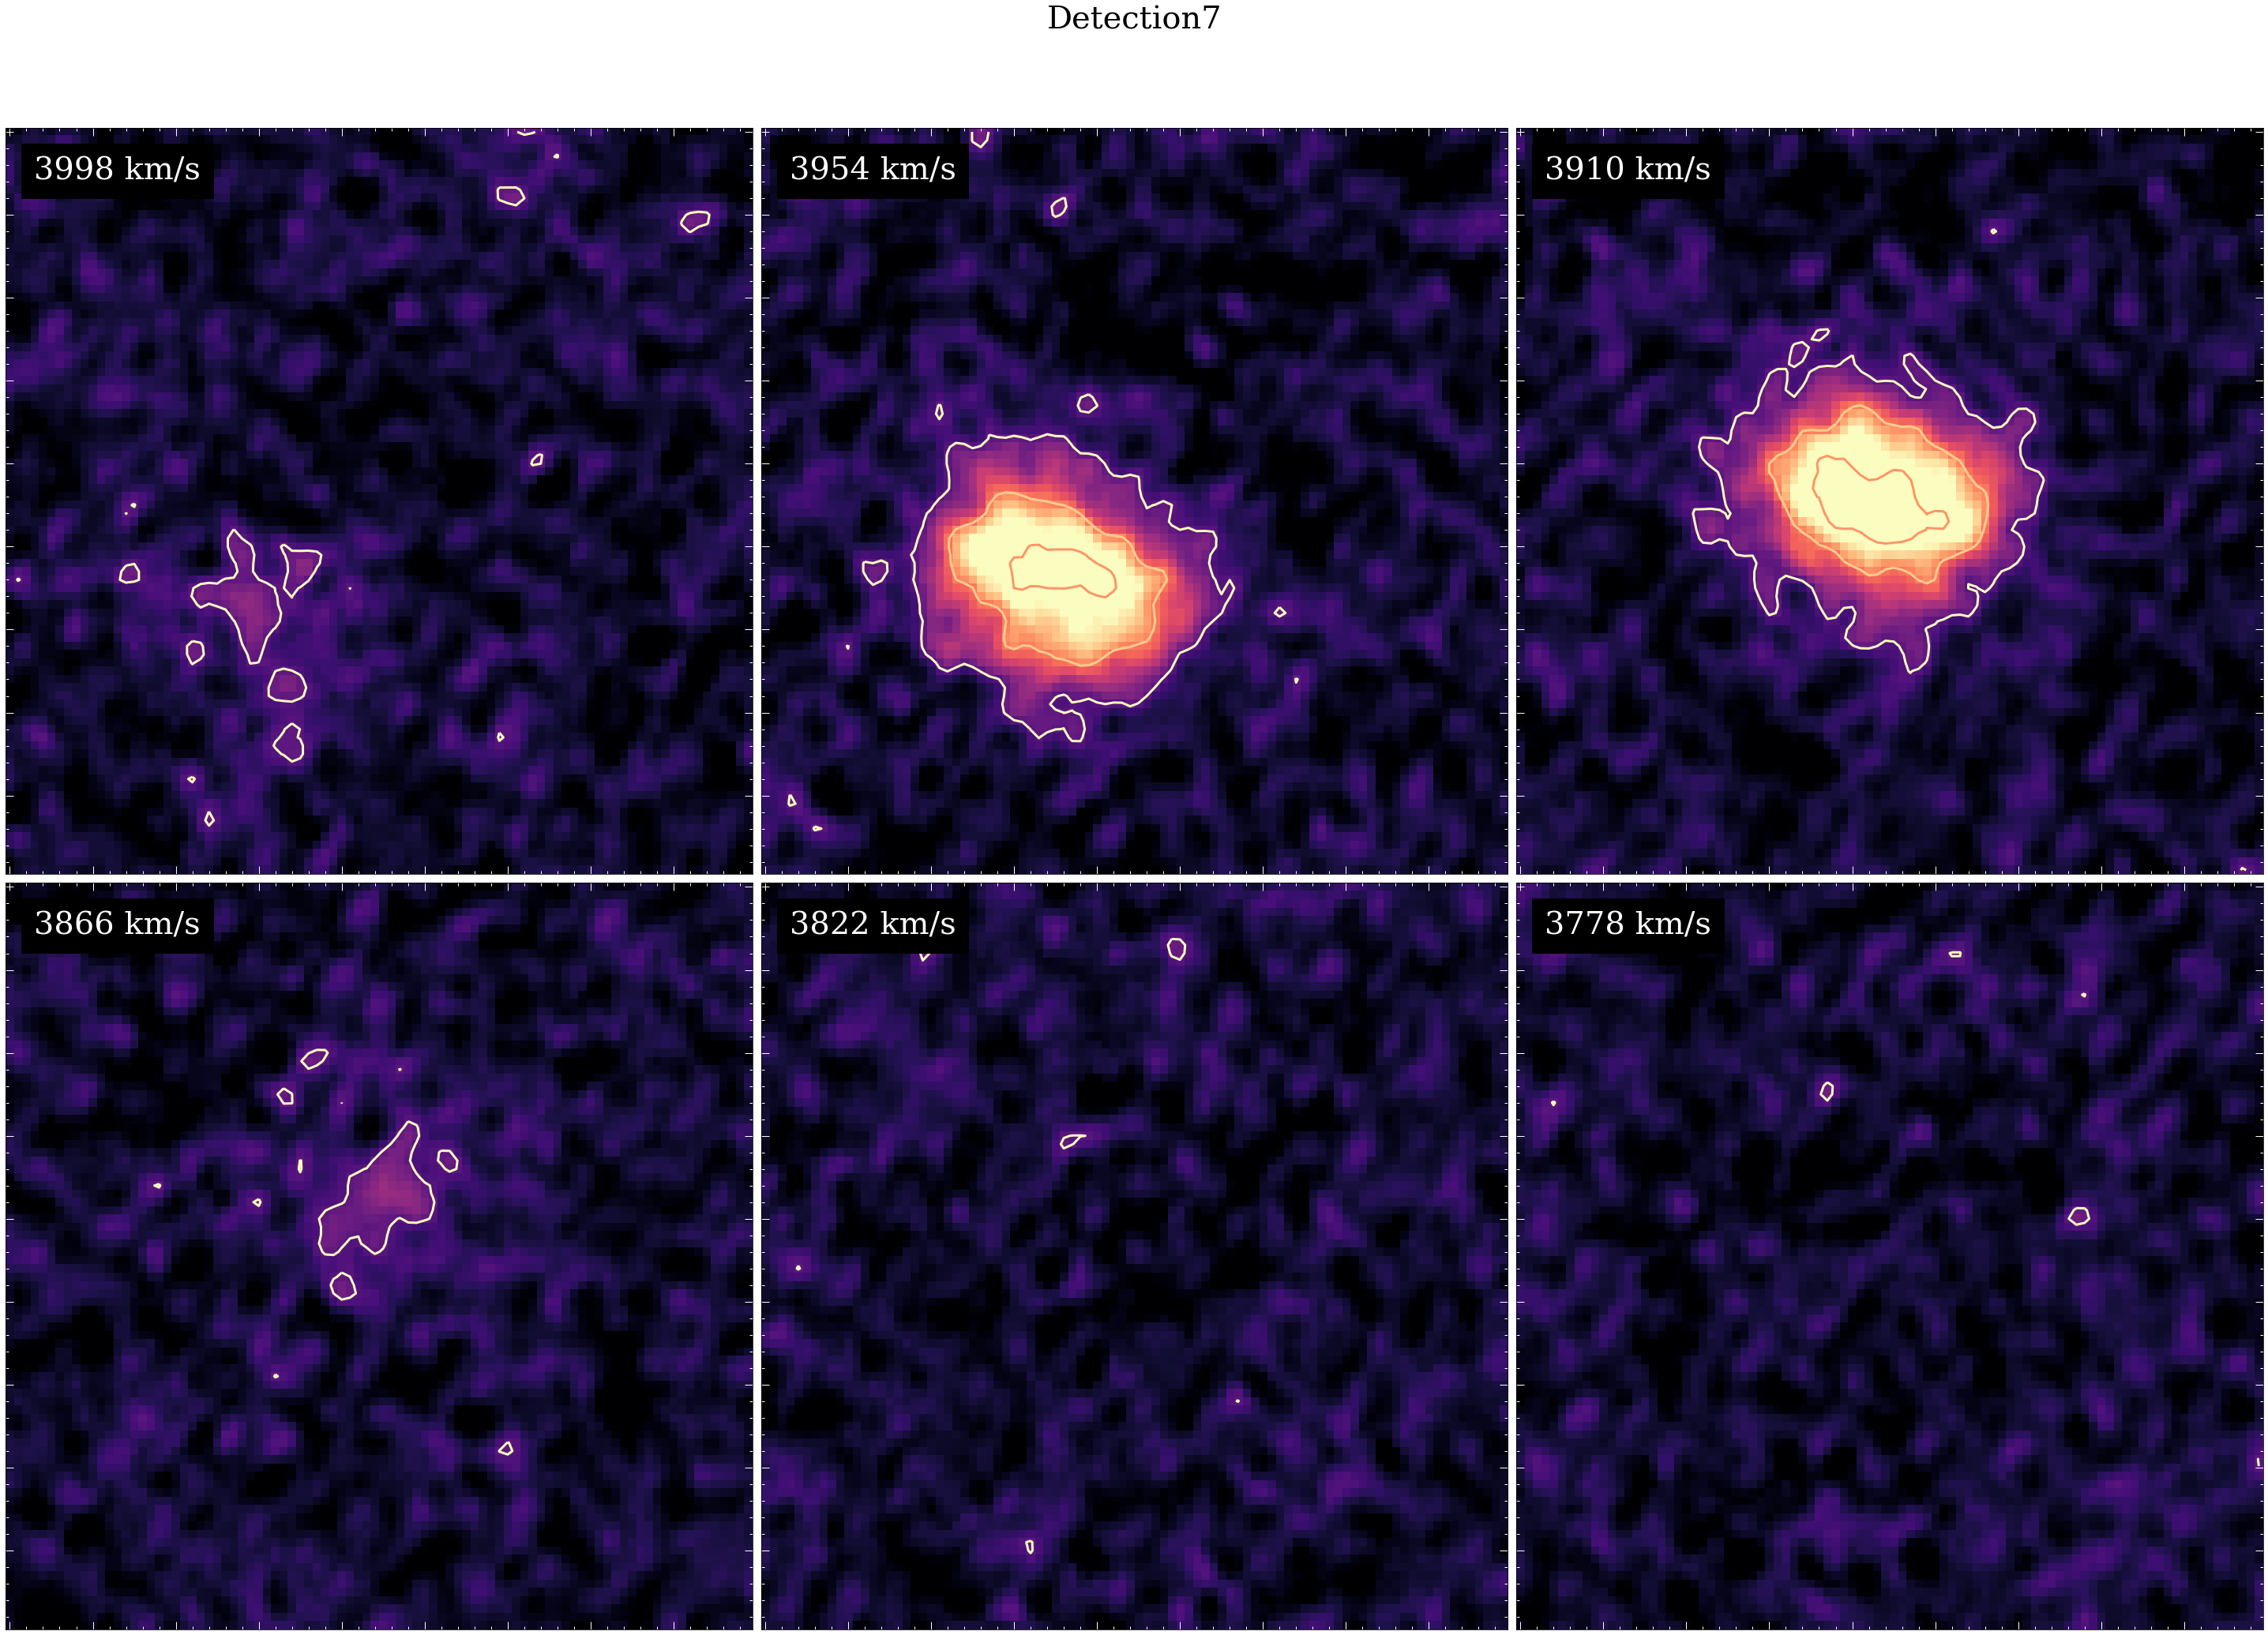

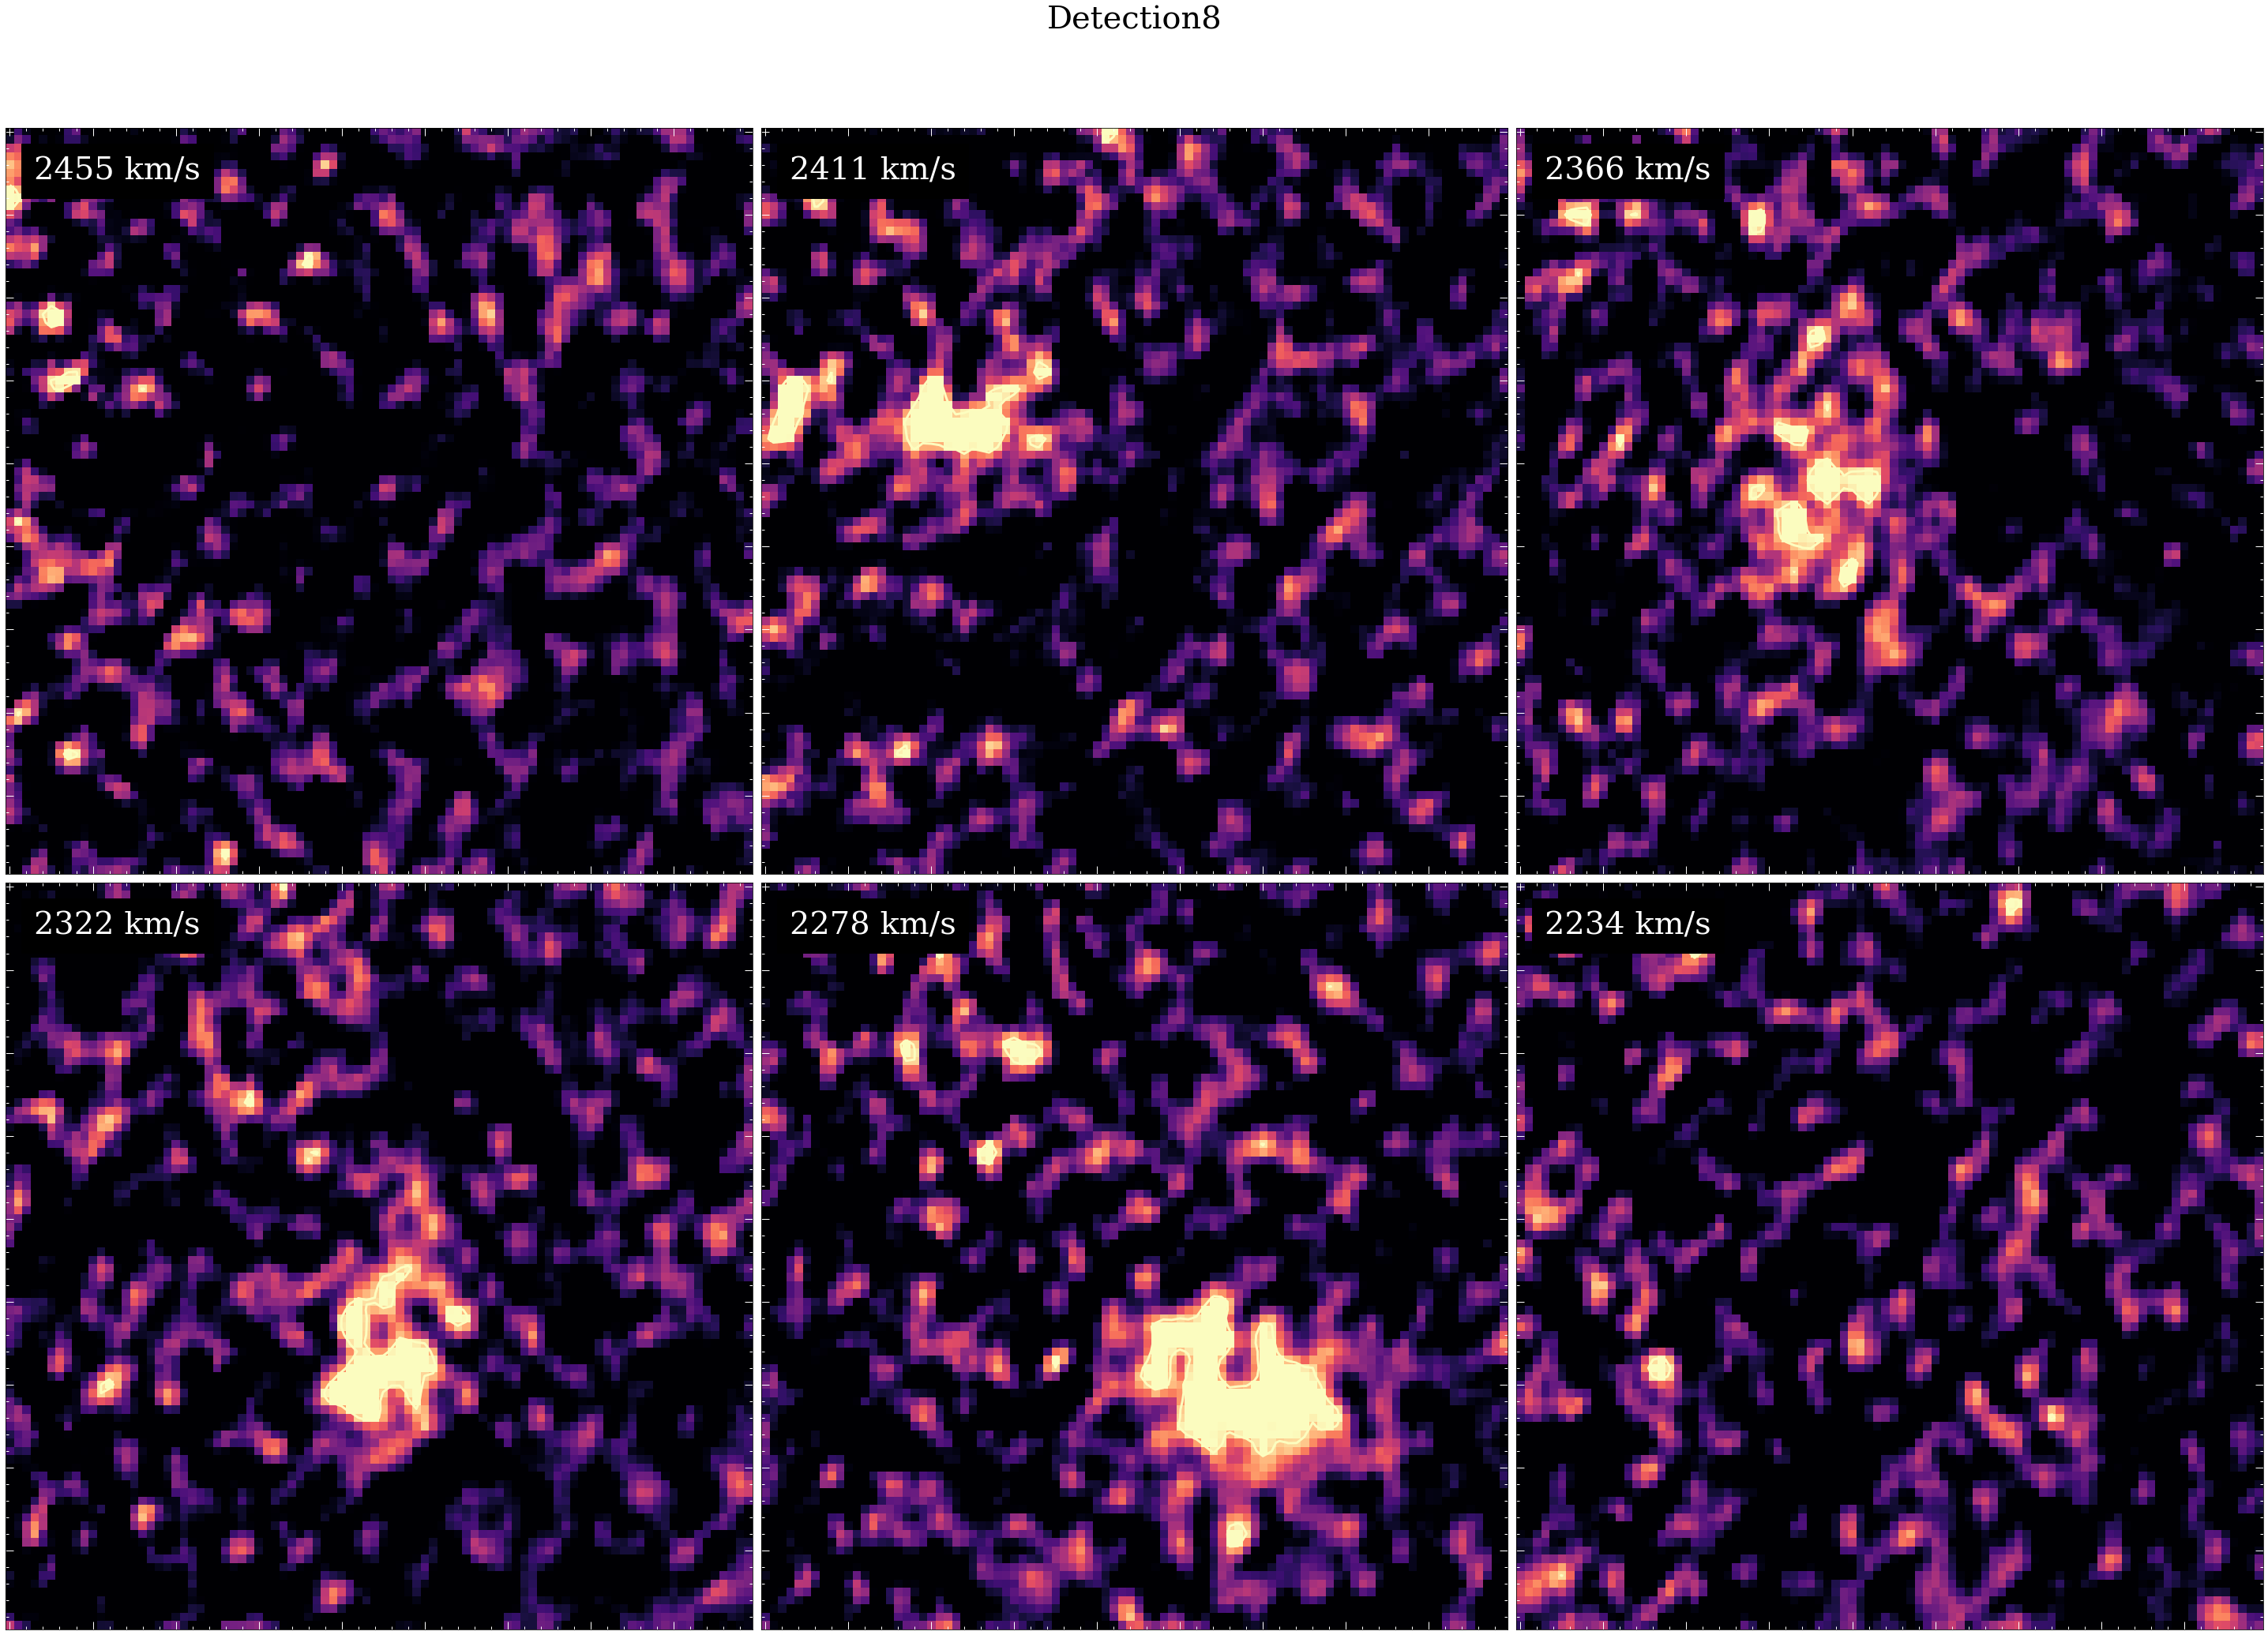

In [14]:
chan = [0, 0, 0, 0, 0, 5, 0, 0]#channels where the channel maps can start
sigma = [2,3,2,3,2,3,3,3] #contour limits

for det in range(len(detections)):
    pl.figure(figsize=(40,40))
    #fig2, ax = pl.subplots()
    sli = vel_subcube[det][0,::1,:].array #for making contour levels
    # It is a 2D slice, so at least one axis should be fixed (and the two last one varies)
    noise = sigma[det]*np.std(sli[np.isfinite(sli)]) #3 sigma threshold, take the
    sub = 0
    for i in range(chan[det],chan[det]+6):
        pl.subplot(3,3,sub+1)
        #inversing the declination
        x = vel_subcube[det][i+1,::1,:].array
        pl.imshow(x[::-1,:], vmin=-0.1e-3, vmax=1e-3,cmap='magma') #I converted the declination axis because when I looked
        # into the detection with carta, the detections in python seems to be plotted with an inversed declination
        if det == 2:
            pl.imshow(x[::-1,:], vmin=-0.1e-4, vmax=3e-4,cmap='magma')
        if det == 7:
            pl.imshow(x[::-1,:], vmin=-0.1e-4, vmax=5e-3,cmap='magma')
            
        pl.contour(x[::-1,:], levels=np.arange(noise, 5e-3, 5e-4), 
                   colors=None,cmap='magma_r',linewidths=3) #changing the levels will change the contours
        ax = pl.gca()
        ax.minorticks_on()
        ax.tick_params(which='major', length=10, width=1, direction='in',color='white')
        ax.tick_params(which='minor', length=4, width=1, direction='in',color='white')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        int_vel = int(np.array(vel[det][i]))
        
        Afont = {'family': 'serif',
        'backgroundcolor': 'black',
        'alpha': 1,
        'color':  'white',
        'weight': 'normal',
        'size': 40,
        }
        anchored_text = AnchoredText(str(int_vel)+' km/s',loc=2, borderpad=0.5,frameon=True,prop=Afont)
        
             #bbox={'boxstyle': 'square','facecolor': 'black', 'alpha': 0.8}
             #)
        
        ax.add_artist(anchored_text)
        sub += 1
    pl.suptitle('Detection'+str(det+1),fontsize=40,y=1.05)
    pl.subplots_adjust(wspace=-0.05, hspace=0.0)
    pl.tight_layout()
    #pl.savefig('/users/aycha/MIGHTEE/Analysis/1380/plots/multi-channels_det'+str(det+1)+'.png', overwrite=True)

#### 5.1.2 Getting the velocity range (optional)

In [15]:
#for the companion, we really need to be careful
v_a = []
v_b = []
vel_limit = ascii.read('vel_limit.dat')
for i in range(len(detections)):
    v_a.append(vel_limit[i]['v_a'])
    v_b.append(vel_limit[i]['v_b'])

index_a = [] #precised index of the velocity limits
index_b = []
#central_vel = []
for i in range(len(detections)):
    x = vel[i].value
    #rather than demand an exact match, should find the closest one
    index_b.append(min(range(len(x)), key=lambda k: abs(x[k]-v_a[i])))
    index_a.append(min(range(len(x)), key=lambda k: abs(x[k]-v_b[i])))
    #central_vel.append(((vel[i][index_a[i]]+vel[i][index_b[i]])/2).value)

#### 5.1.3. Clipping the subcube (optional)

In [18]:
#Selecting only a few channels for detection 6

common_cube = []
circ_cube = []
for i in range(len(detections)):
    if i ==5:
        common_cube.append(vel_subcube[i][index_a[i]:index_b[i]+1])
        circ_cube.append(smoothed_cube[i][index_a[i]:index_b[i]+1])
    else:
        common_cube.append(vel_subcube[i])
        circ_cube.append(smoothed_cube[i])

#### 5.1.4 Making the moment maps, and adjusting the mask

The moment maps will now depend on the mask threshold we are using.
We can use the circular cube and its rms as a mask for the common beam cube.

In [45]:
sigma_common = [3,3.8,2.3,2.5,3.5,2,3,1.8] #for moment 1 common
sigma_circ = [3.5,5,4,4,7,2,5,2] 
mom0_common = [moment_fits(common_cube[i], circ_cube[i], mean_rms_circ[i], get_fits=True, 
                           dirName=dirName, folder2='detection'+str(i+1), name='mom_mask_circ',sigma = sigma_circ[i])[0] for i in range(len(detections))]
mom1_common = [moment_fits(common_cube[i], common_cube[i], mean_rms_common[i], get_fits=True, 
                           dirName=dirName, folder2='detection'+str(i+1), name='mom_mask_common', sigma = sigma_common[i])[1] for i in range(len(detections))]
mom0_circ = [moment_fits(circ_cube[i], circ_cube[i], mean_rms_circ[i], get_fits=True,
                         dirName=dirName, folder2='detection'+str(i+1), name='mom_circ', sigma = sigma_circ[i])[0] for i in range(len(detections))]
mom1_circ = [moment_fits(circ_cube[i], circ_cube[i], mean_rms_circ[i], sigma = sigma_circ[i])[1] for i in range(len(detections))]

Directory  Moment_maps_1380  Created 
Directory  Moment_maps_1380  already exists
Directory  Moment_maps_1380  already exists
Directory  Moment_maps_1380  already exists
Directory  Moment_maps_1380  already exists
Directory  Moment_maps_1380  already exists
Directory  Moment_maps_1380  already exists
Directory  Moment_maps_1380  already exists
Directory  Moment_maps_1380  already exists
DirectoryMoment_maps_1380/detection1already exists
Directory  Moment_maps_1380  already exists
DirectoryMoment_maps_1380/detection2already exists
Directory  Moment_maps_1380  already exists
DirectoryMoment_maps_1380/detection3already exists
Directory  Moment_maps_1380  already exists
DirectoryMoment_maps_1380/detection4already exists
Directory  Moment_maps_1380  already exists
DirectoryMoment_maps_1380/detection5already exists
Directory  Moment_maps_1380  already exists
DirectoryMoment_maps_1380/detection6already exists
Directory  Moment_maps_1380  already exists
DirectoryMoment_maps_1380/detection7alre

#### Moment maps with the same color bar for different beams

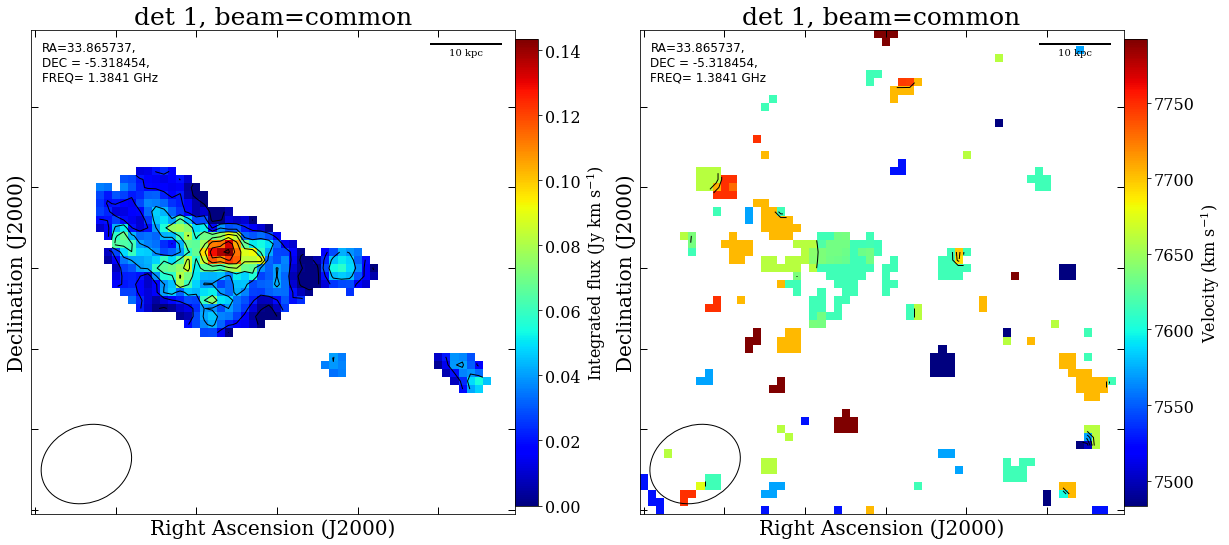

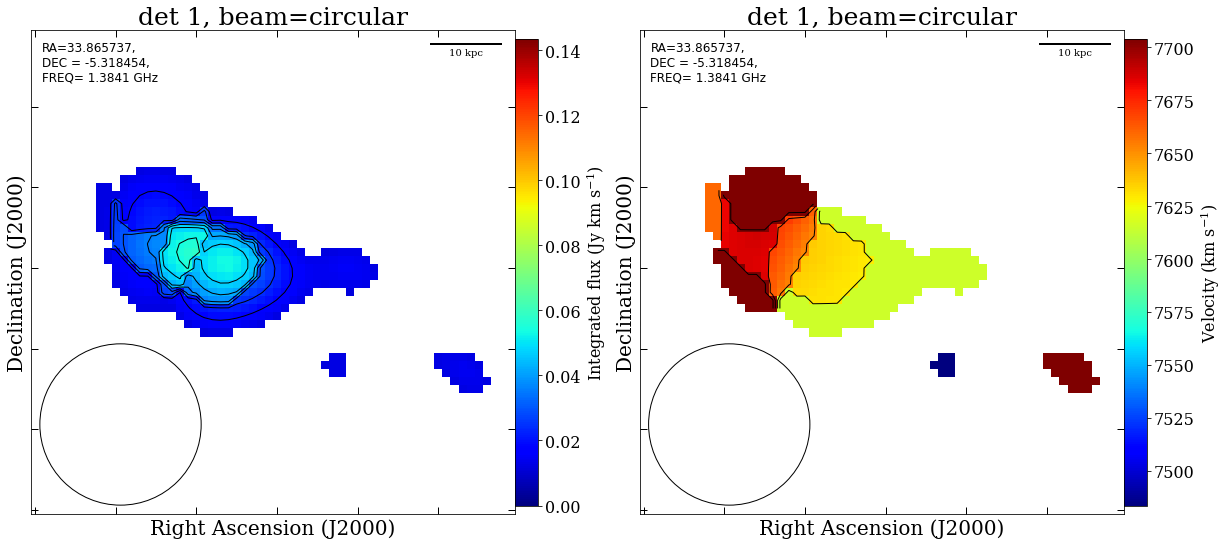

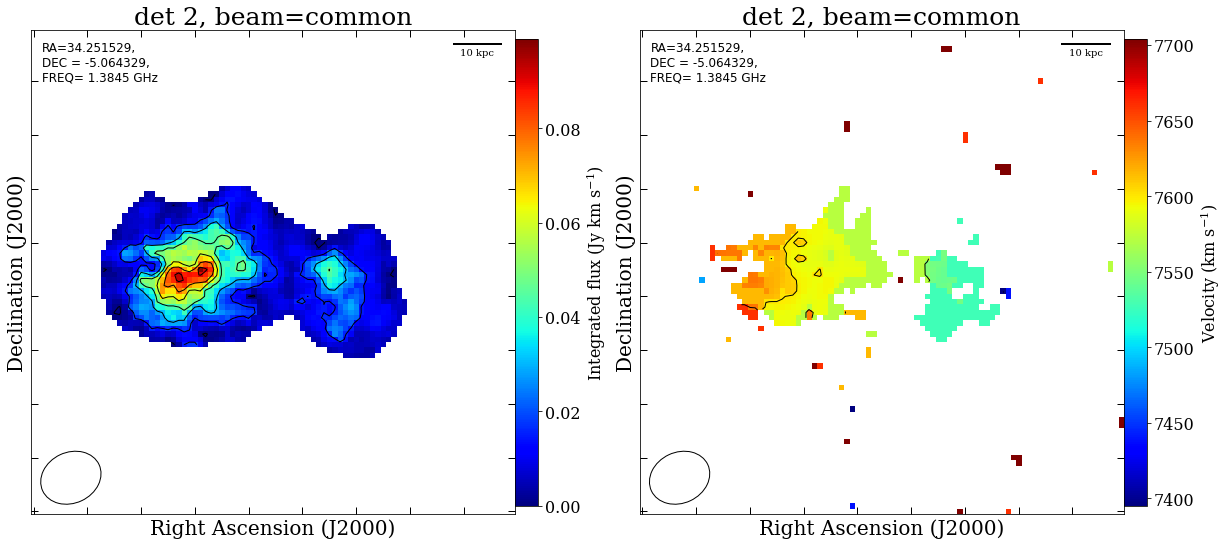

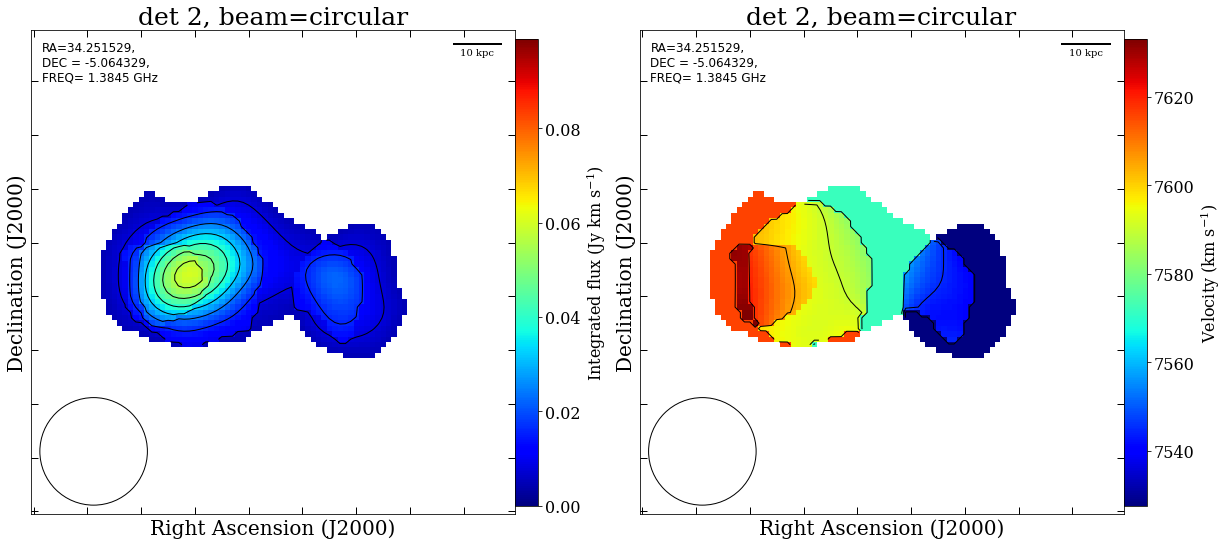

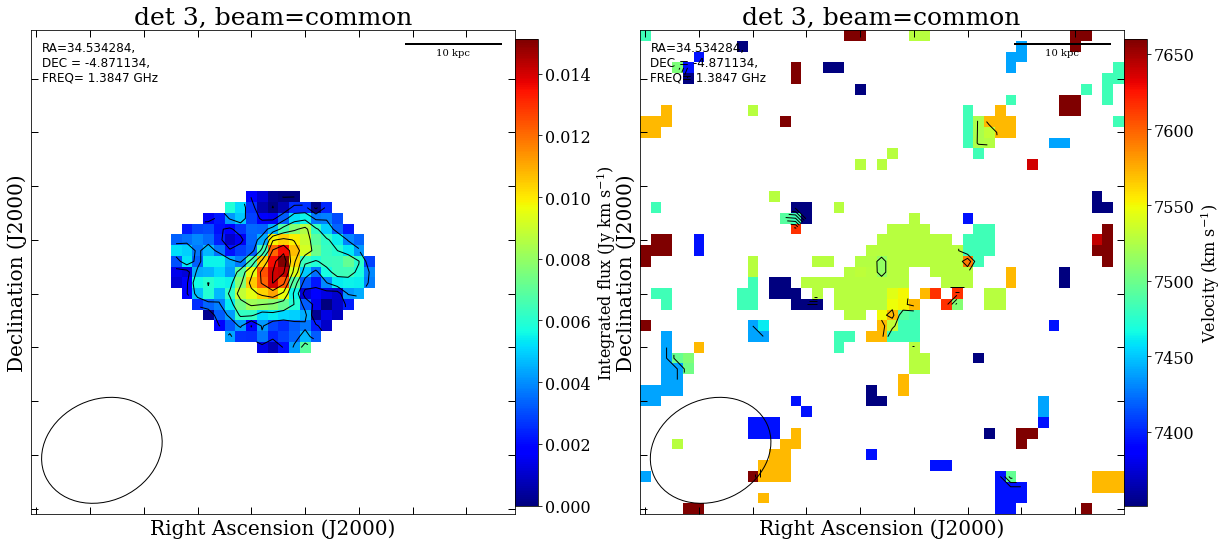

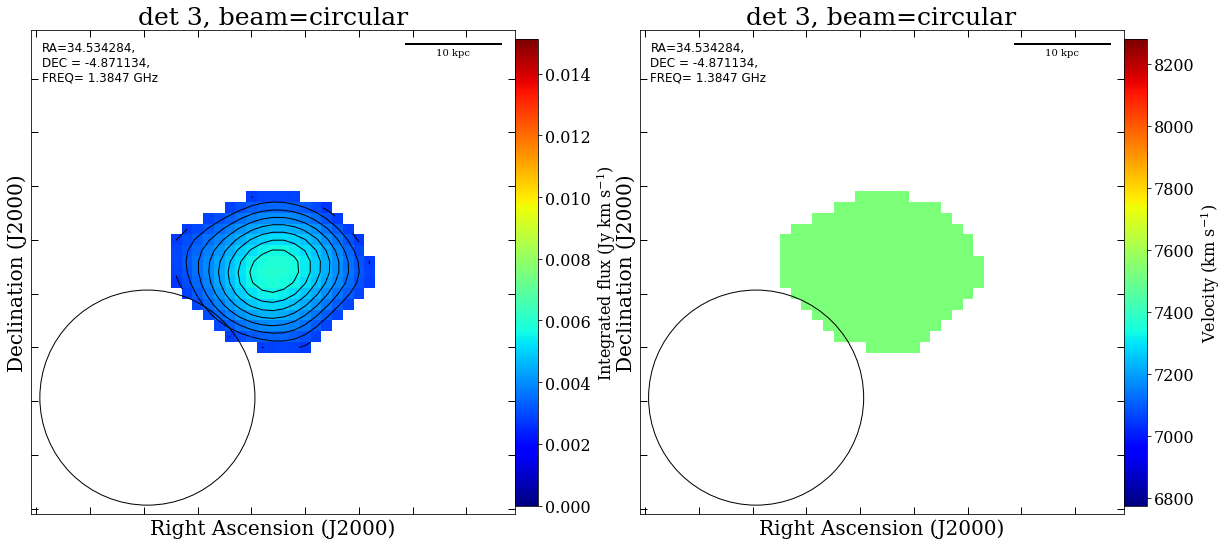

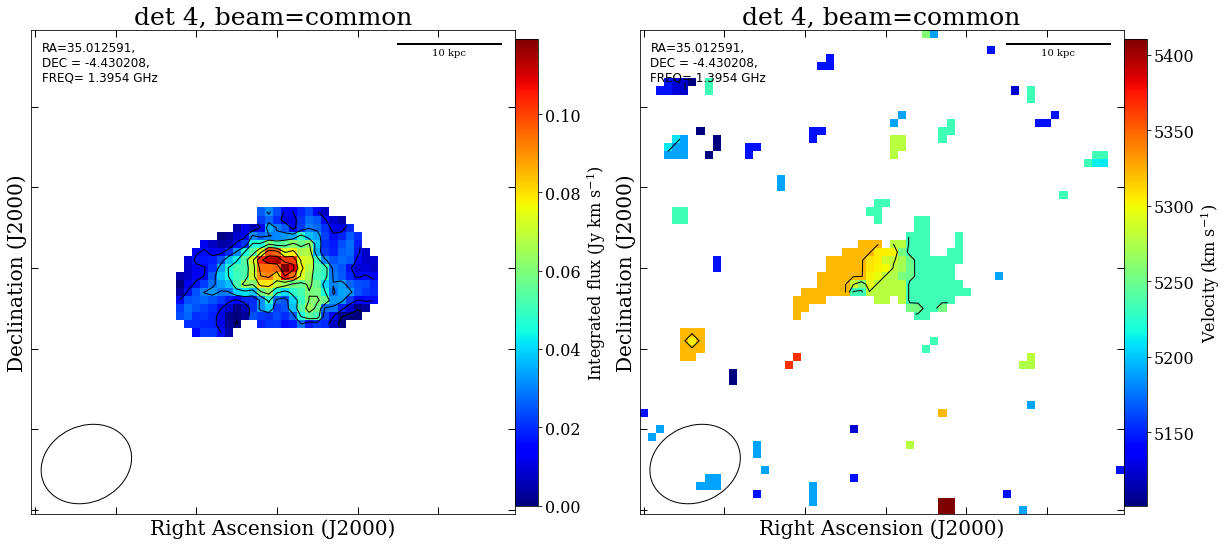

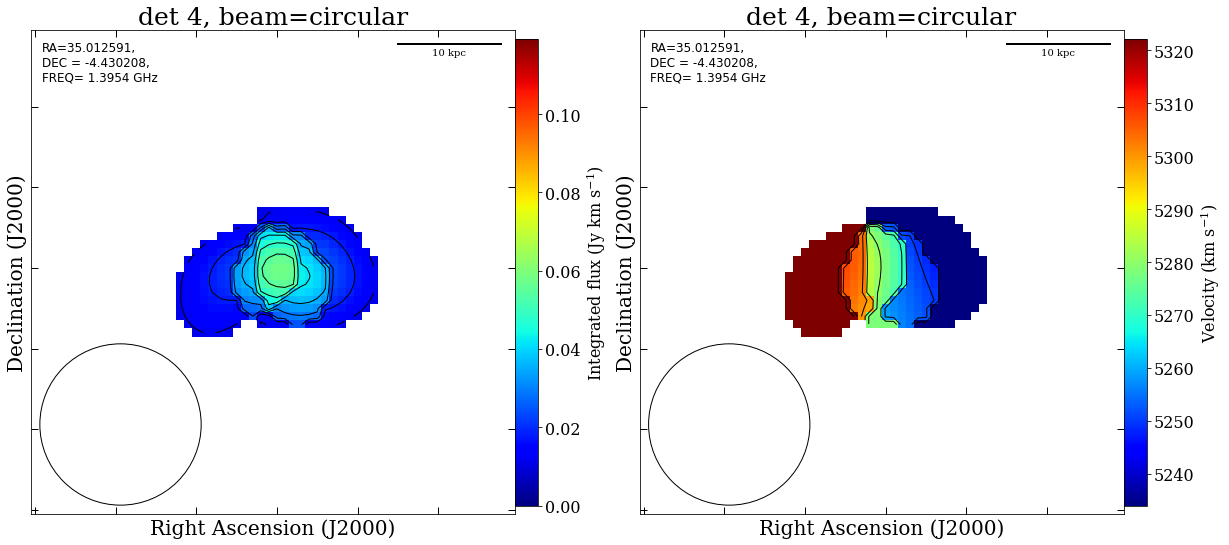

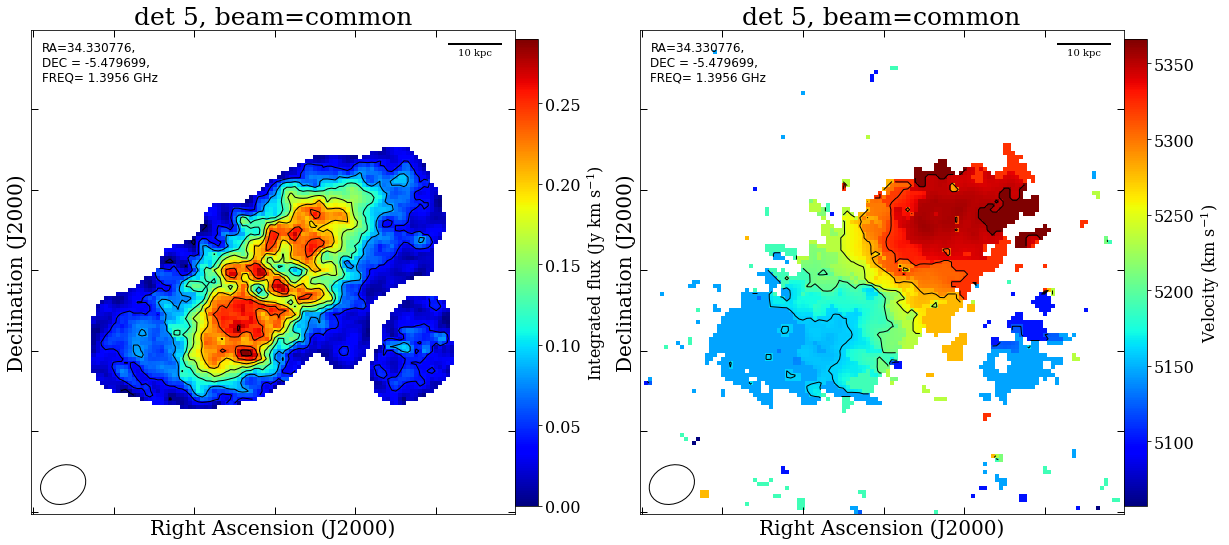

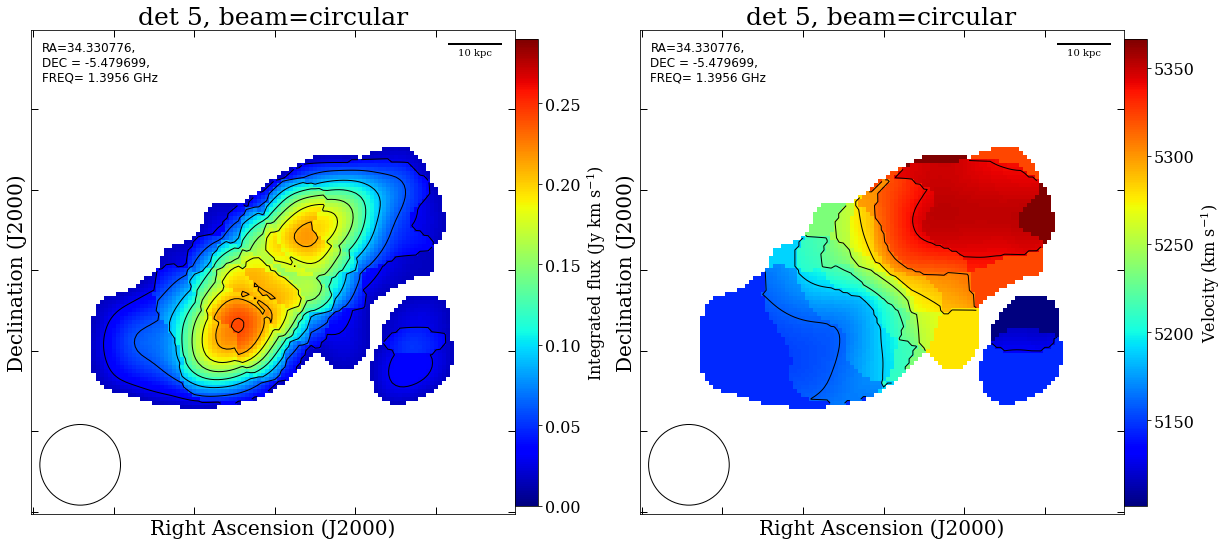

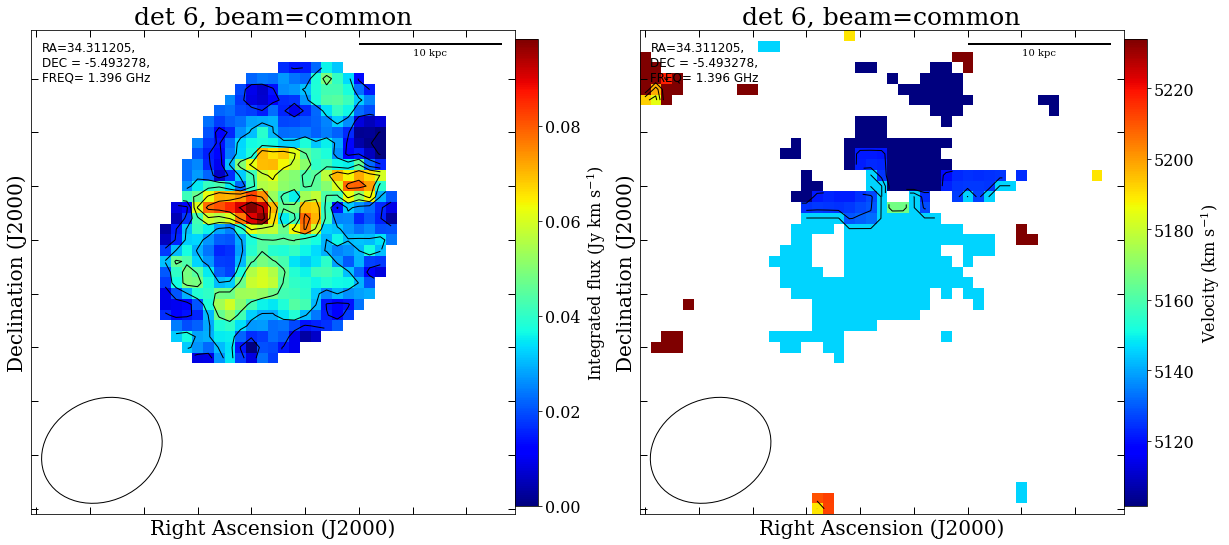

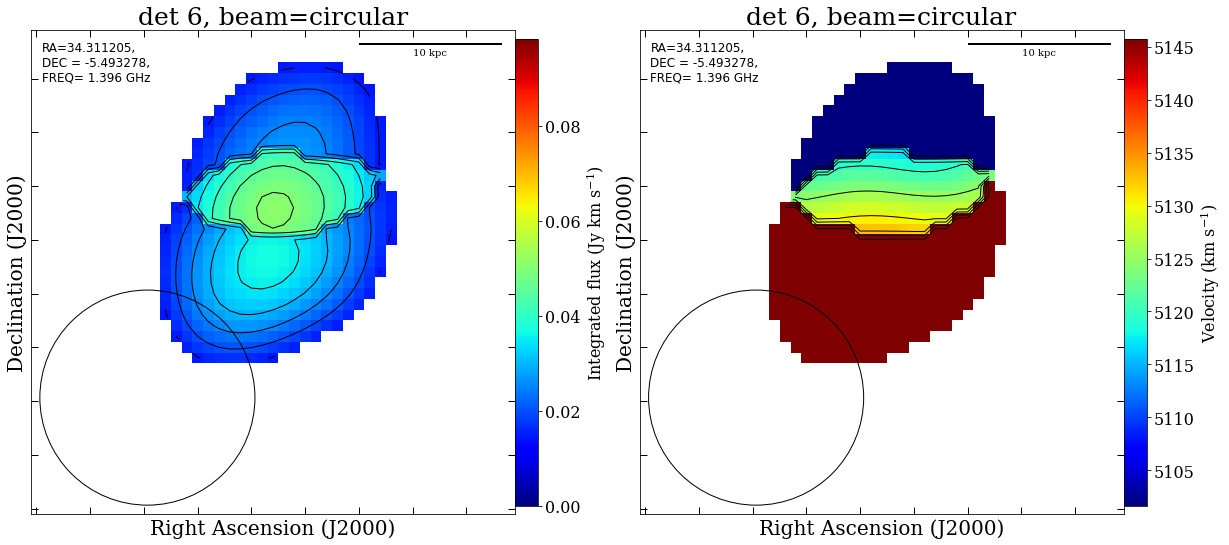

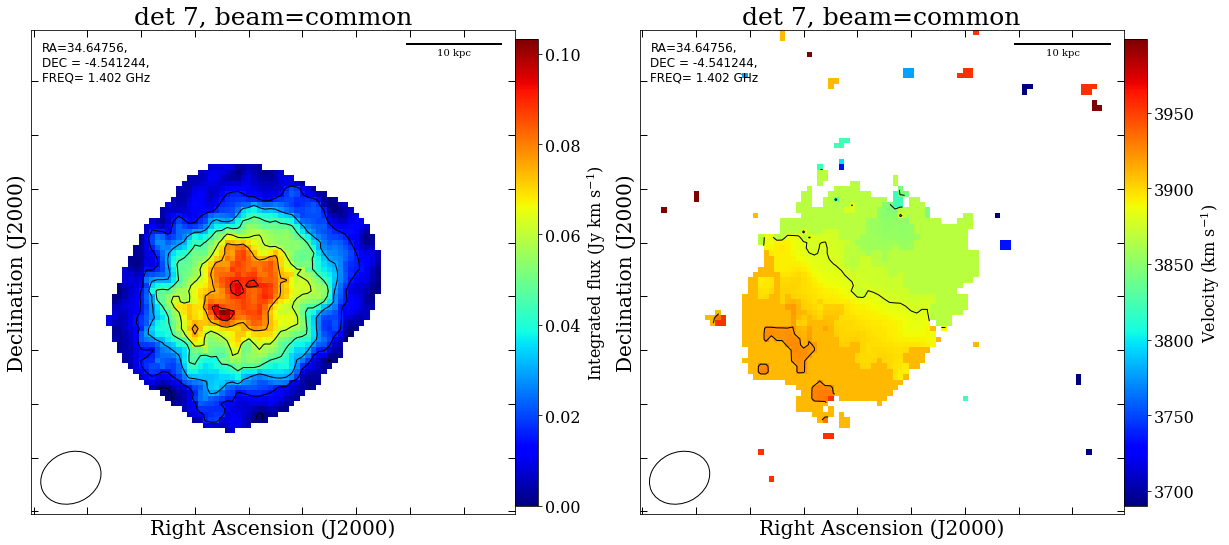

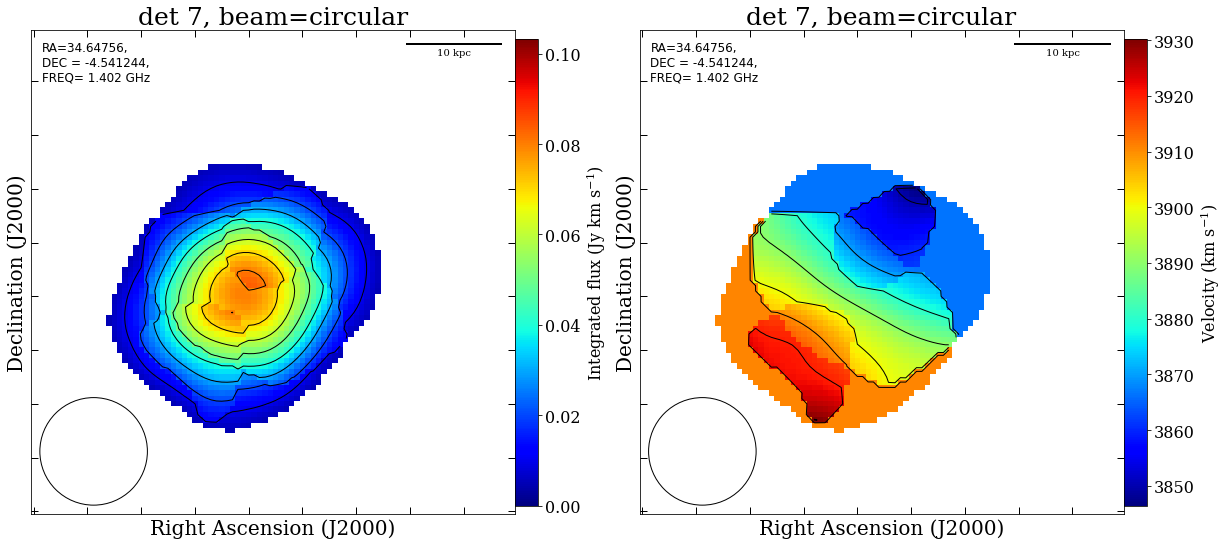

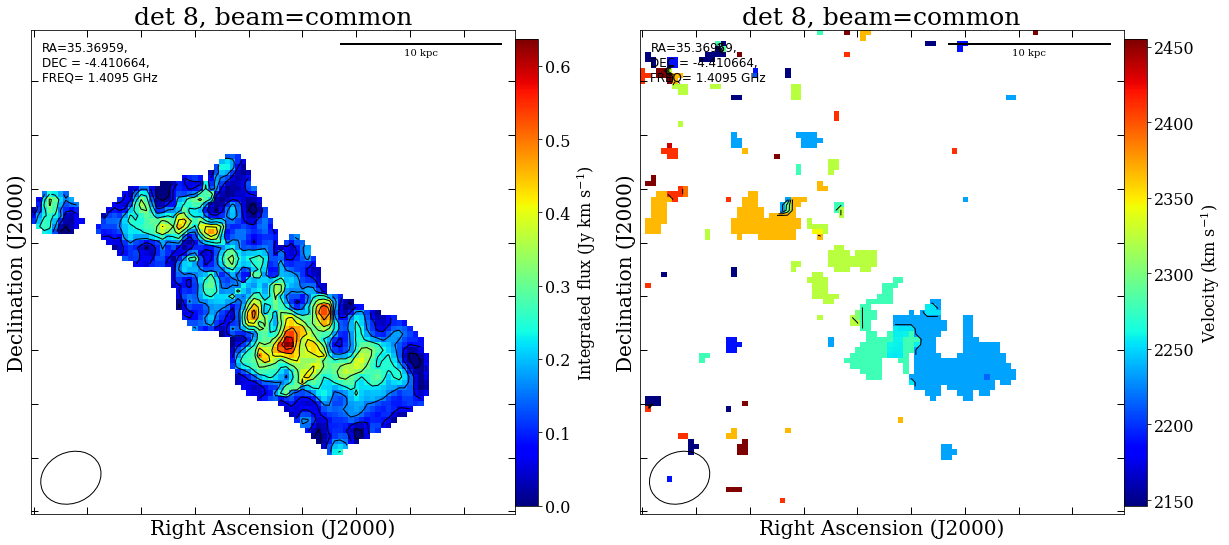

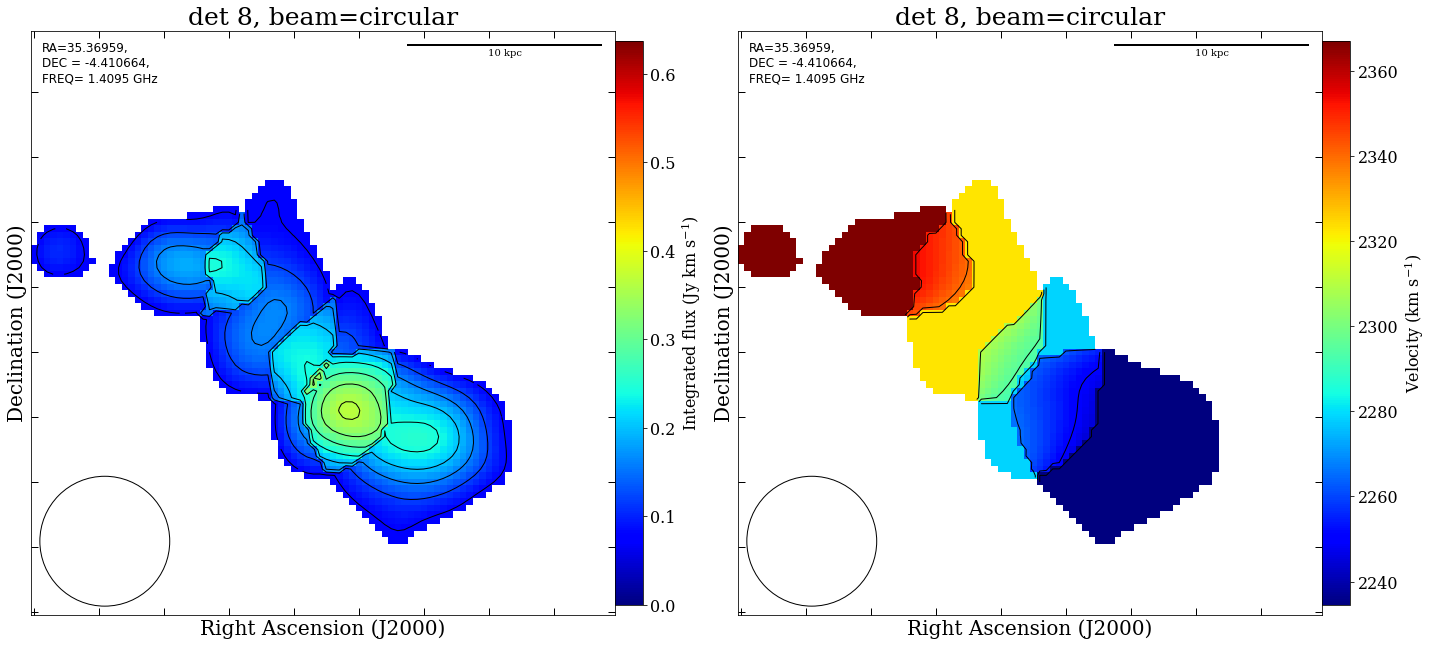

In [31]:
#Moment maps

beam_str = ['common','circular']
beam = [common_beam,circular_beam] #different beam convolution
#rms = [mean_rms_common,mean_rms_beam50,mean_rms_circular]
#subcube = [vel_common2,vel_beam50,vel_circular] #convolved beams
sigma = 3
mom0 = [mom0_common, mom0_circ]
mom1 = [mom1_common, mom1_circ]

for i in range(len(detections)):
    #if not os.path.exists(dirName+'/detection_'+str(i+1)):
        #os.makedirs(dirName+'/detection_'+str(i+1))
    #else:
        #shutil.rmtree(dirName+'/detection_'+str(i+1))
        #os.makedirs(dirName+'/detection_'+str(i+1))
    for j in range(len(beam)):
        #mom0, mom1 = moment_fits(subcube[j][i], rms[j][i], 'det '+str(i+1)+', beam='+beam_str[j], sigma = sigma)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
        
        #ax = fig.add_subplot(1,2,1,projection=subcube[j][i][1].wcs)
        
        moment_0(mom0[j][i], np.nanmax(mom0_common[i]), beam[j], bar_10_kpc[i], ax1, str(detections[i]['ra']), str(detections[i]['dec']), str(detections[i]['freq']), 
                 title='det '+str(i+1)+', beam='+beam_str[j])
        #plt.savefig(dirName+'/detection_'+str(i+1)+'/mom0_det_'+str(i+1)+'_'+beam_str[j]+'_beam',overwrite=True, bbox_inches = "tight")
        #ax = fig.add_subplot(1,2,2,projection=subcube[j][i][1].wcs)
        moment_1(mom1[j][i],beam[j],bar_10_kpc[i], ax2, str(detections[i]['ra']), str(detections[i]['dec']), str(detections[i]['freq']),
                 title='det '+str(i+1)+', beam='+beam_str[j])
        #plt.savefig(dirName+'/detection_'+str(i+1)+'/mom1_det_'+str(i+1)+'_'+beam_str[j]+'_beam',overwrite=True, bbox_inches = "tight")
pl.subplots_adjust(hspace=0.5,wspace=0.0)
plt.tight_layout()

### 5-2 Moment maps Visualization in the same colorbar

In [63]:
max_common = [np.nanmax(mom0_common[i]) for i in range(len(detections))]
max_all_circ = [np.nanmax(mom0_circ[i]) for i in range(len(detections))]

Text(0.5, 0, 'Integrated flux (Jy/beam km s$^{-1}$)')

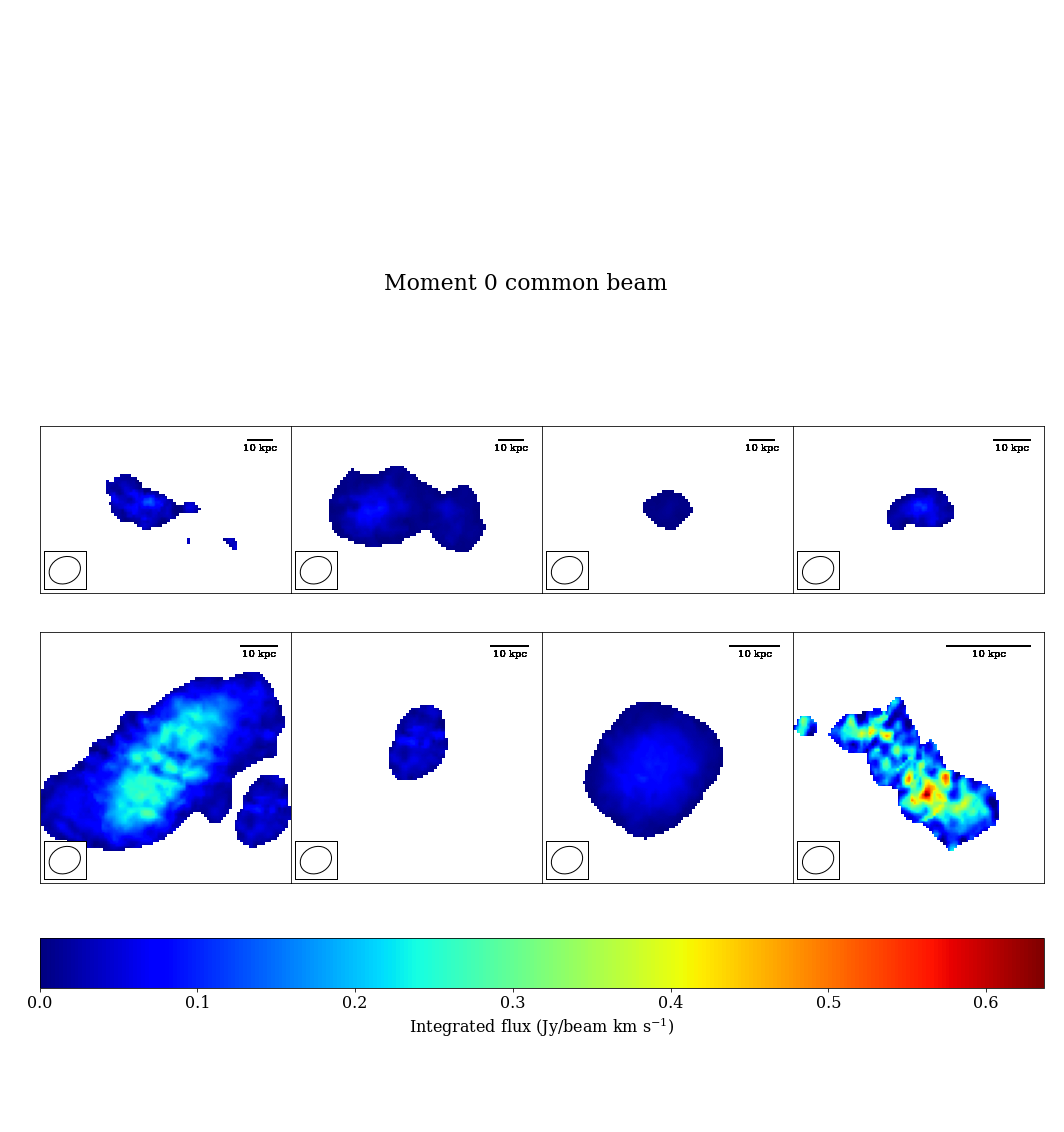

In [64]:
fig, axs = plt.subplots(2, 4, figsize=(18, 20), sharex=True, sharey='row',
                        gridspec_kw={'hspace': -0.5, 'wspace': 0},subplot_kw={'aspect': 2})
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

fig.suptitle('Moment 0 common beam',fontsize=22,y=0.7)

nrows, ncols = 2, 4
ax = [ax1,ax2,ax3,ax4,ax5,ax6, ax7, ax8]
beam = [common_beam,circular_beam]
for i in range(len(detections)):
    j = 1
    for row in range(nrows):
        for col in range(ncols):
            k = j
            cmap = cm.jet
            cmap.set_bad('white')
            
            #Put the same aspect as the biggest image
            im = ax[i].imshow(mom0_common[i], cmap=cmap, vmin=0, vmax=np.nanmax(max_common),
                              extent=[-mom0_common[i].shape[1]/2., mom0_common[i].shape[1]/2., -mom0_common[i].shape[0]/2., mom0_common[i].shape[0]/2. ])
            ax[i].axes.xaxis.set_ticks([])
            ax[i].axes.yaxis.set_ticks([])
            ax[i].tick_params(which='major', length=7, width=1, direction='in')
            pl.setp(ax[i].get_yticklabels(), visible=False)
            pl.setp(ax[i].get_xticklabels(), visible=False)
            ax[i].yaxis.set_ticks_position('both')
            ax[i].xaxis.set_ticks_position('both')
            ax[i].invert_yaxis()
            #contours = ax[i].contour(mom0_common_mf[i][::-1,:], levels=6, c='black')
            ob = AnchoredHScaleBar(size=bar_10_kpc[i], label='10 kpc', loc=1, frameon=False,
                               pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
            ax[i].add_artist(ob)
            draw_ellipse(ax[i],beam[0].major.to(u.arcsec).value,beam[0].minor.to(u.arcsec).value,beam[0].pa.to(u.deg).value)
            j = k+1

for ax in axs.flat:
    ax.label_outer()
#fig.delaxes(axs[1,2]) #if deleting axes

#Common xlabels
fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#plt.xlabel("Declination (J2000)",labelpad=-100,fontsize=22)
#plt.ylabel("Right Ascension (J2000)",labelpad=-20,fontsize=22)

cbar = plt.colorbar(im,pad=0.05,orientation='horizontal',ax=axs)
cbar.ax.set_xlabel(r'Integrated flux (Jy/beam km s$^{-1}$)')
#plt.savefig('fits_detections/mom0_same_cbar_common.png',format = 'png',\
             #bbox_inches = 'tight', transparent=True)

Text(0.5, 0, 'Integrated flux (Jy km s$^{-1}$)')

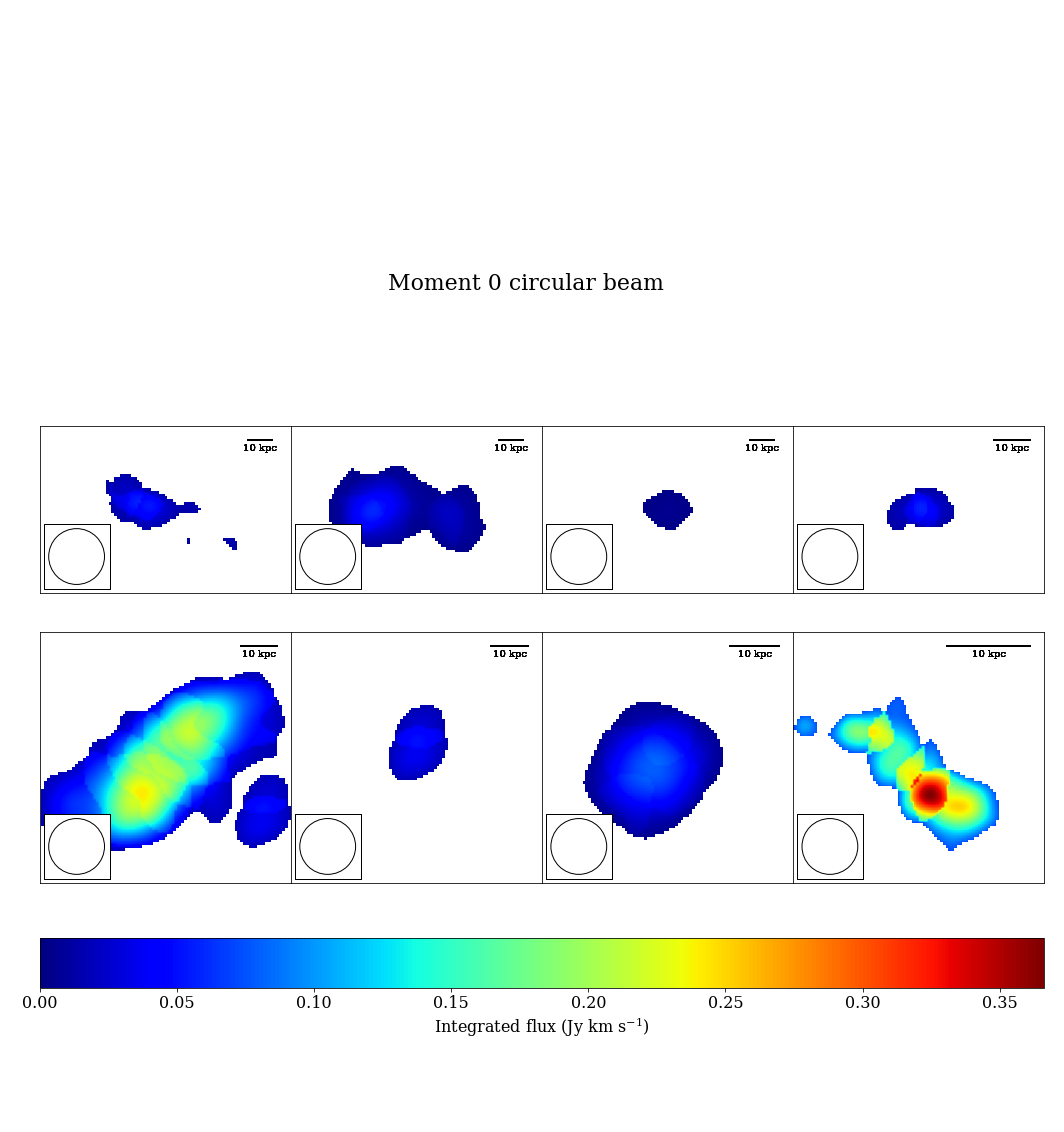

In [65]:
fig, axs = plt.subplots(2, 4, figsize=(18, 20), sharex=True, sharey='row',
                        gridspec_kw={'hspace': -0.5, 'wspace': 0},subplot_kw={'aspect': 2})
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

fig.suptitle('Moment 0 circular beam',fontsize=22,y=0.7)

nrows, ncols = 2, 4
ax = [ax1,ax2,ax3,ax4,ax5,ax6, ax7, ax8]
beam = [common_beam,circular_beam]
for i in range(len(detections)):
    j = 1
    for row in range(nrows):
        for col in range(ncols):
            k = j
            cmap = cm.jet
            cmap.set_bad('white')
            
            #Put the same aspect as the biggest image
            im = ax[i].imshow(mom0_circ[i], cmap=cmap, vmin=0, vmax=np.nanmax(max_all_circ),
                              extent=[-mom0_circ[i].shape[1]/2., mom0_circ[i].shape[1]/2., -mom0_circ[i].shape[0]/2., mom0_circ[i].shape[0]/2. ])
            ax[i].axes.xaxis.set_ticks([])
            ax[i].axes.yaxis.set_ticks([])
            ax[i].tick_params(which='major', length=7, width=1, direction='in')
            pl.setp(ax[i].get_yticklabels(), visible=False)
            pl.setp(ax[i].get_xticklabels(), visible=False)
            ax[i].yaxis.set_ticks_position('both')
            ax[i].xaxis.set_ticks_position('both')
            ax[i].invert_yaxis()
            #contours = ax[i].contour(mom0_common_mf[i][::-1,:], levels=6, c='black')
            ob = AnchoredHScaleBar(size=bar_10_kpc[i], label='10 kpc', loc=1, frameon=False,
                               pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
            ax[i].add_artist(ob)
            draw_ellipse(ax[i],beam[1].major.to(u.arcsec).value,beam[1].minor.to(u.arcsec).value,beam[1].pa.to(u.deg).value)
            j = k+1

for ax in axs.flat:
    ax.label_outer()
#fig.delaxes(axs[1,2]) #if deleting axes

#Common xlabels
fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#plt.xlabel("Declination (J2000)",labelpad=-100,fontsize=22)
#plt.ylabel("Right Ascension (J2000)",labelpad=-20,fontsize=22)

cbar = plt.colorbar(im,pad=0.05,orientation='horizontal',ax=axs)
cbar.ax.set_xlabel(r'Integrated flux (Jy km s$^{-1}$)')
#plt.savefig('fits_detections/mom0_same_cbar_common.png',format = 'png',\
             #bbox_inches = 'tight', transparent=True)

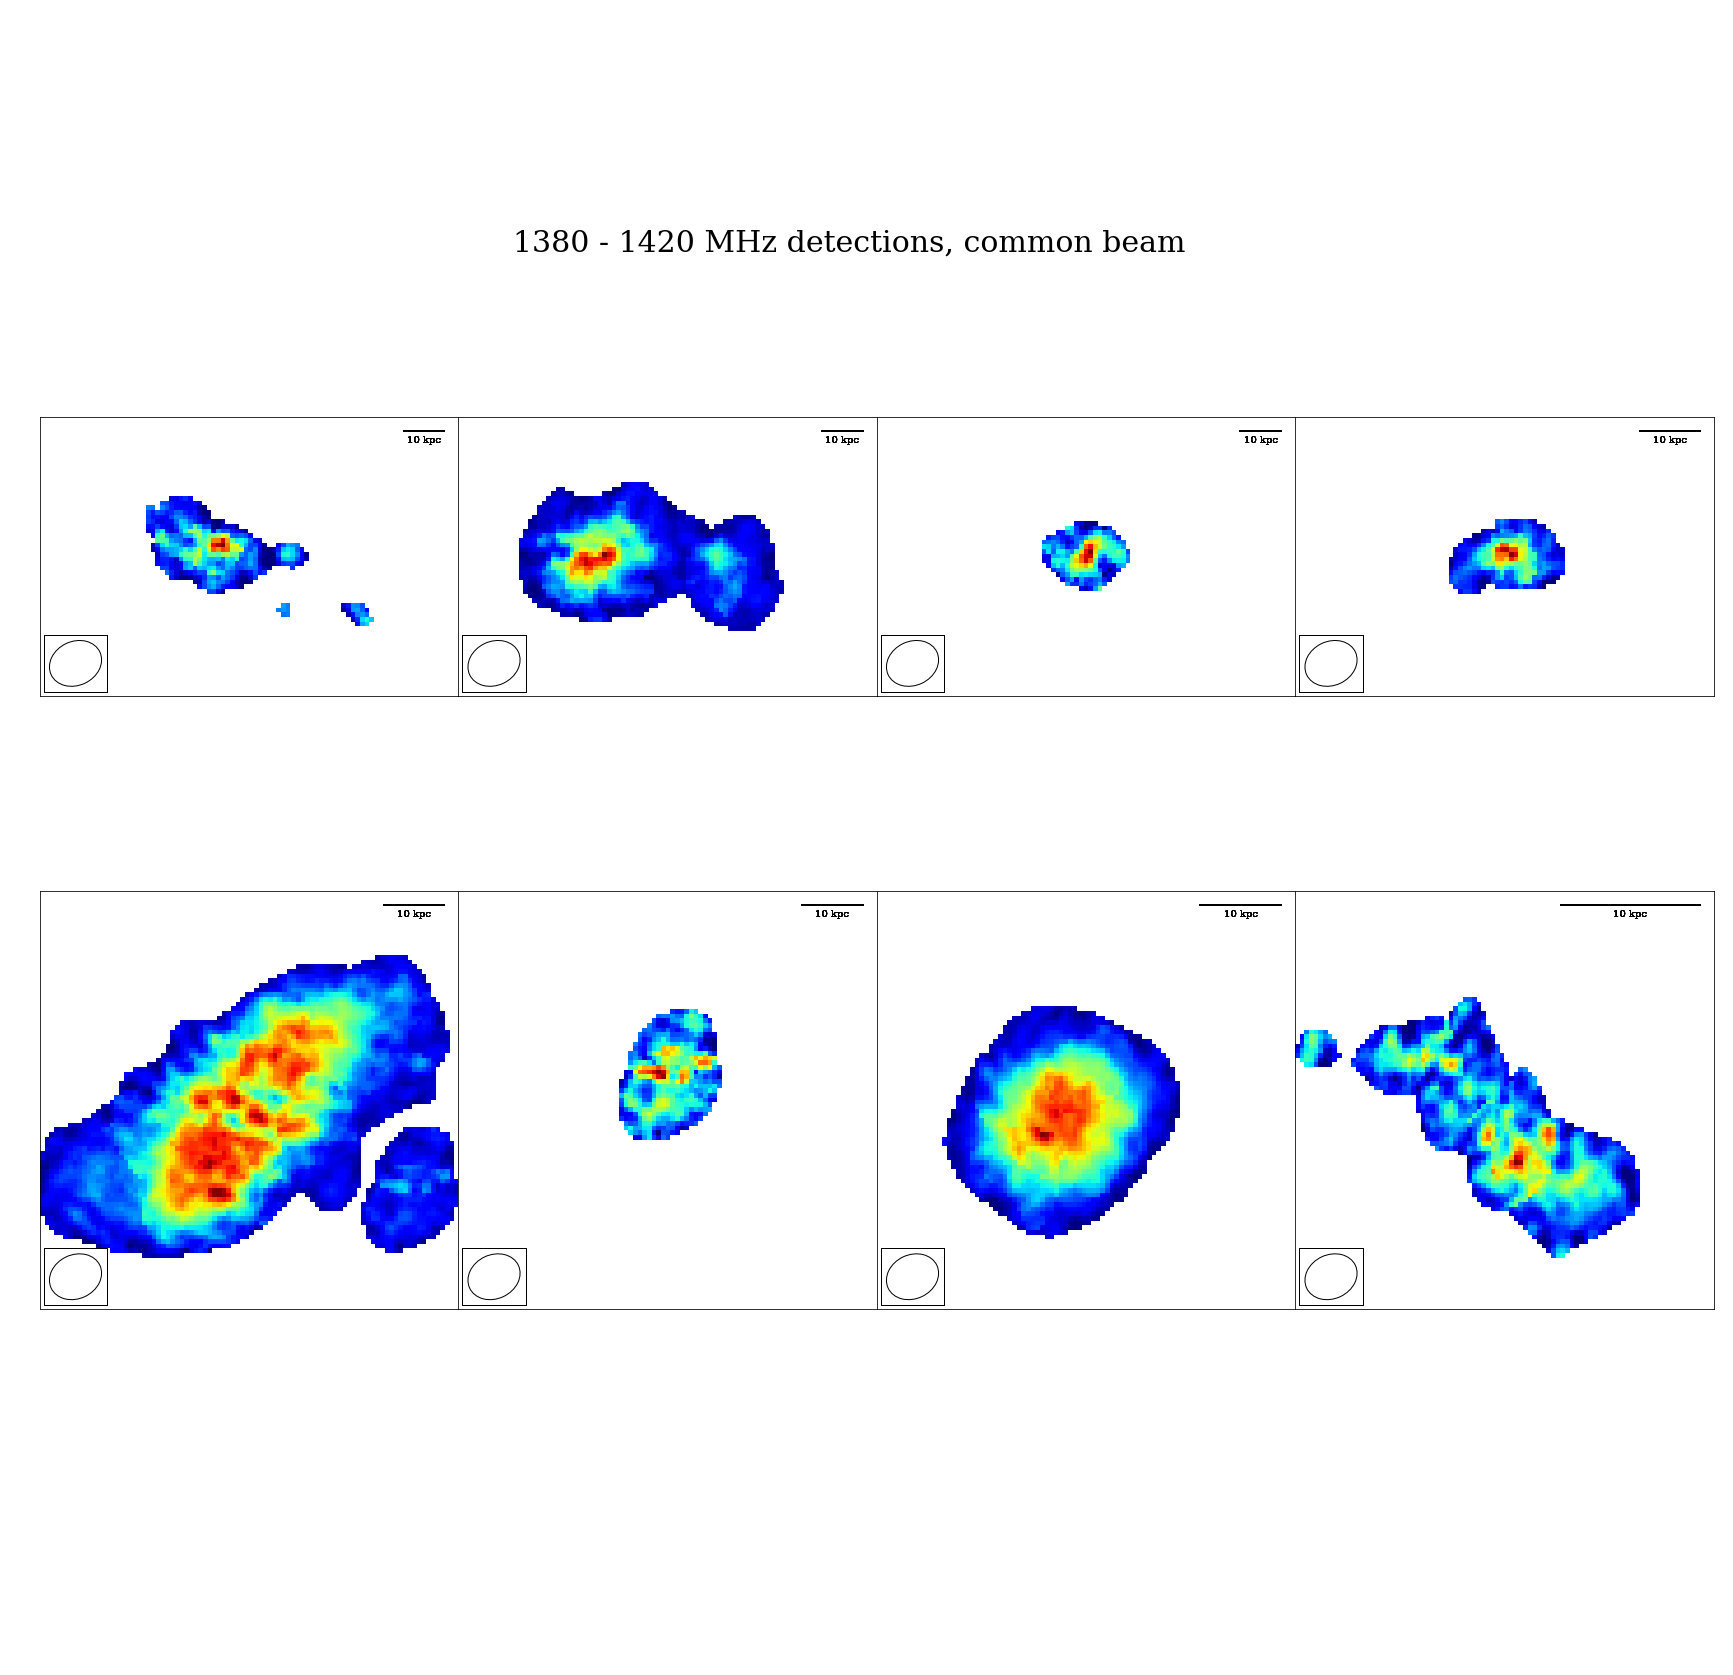

In [67]:
fig, axs = plt.subplots(2, 4, figsize=(30, 30), sharex=True, sharey='row',
                        gridspec_kw={'hspace': -0.5, 'wspace': 0},subplot_kw={'aspect': 2})
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

fig.suptitle('1380 - 1420 MHz detections, common beam',fontsize=30,y=0.78)

nrows, ncols = 2, 4
ax = [ax1,ax2,ax3,ax4,ax5,ax6, ax7, ax8]
beam = [common_beam,circular_beam]
for i in range(len(detections)):
    j = 1
    for row in range(nrows):
        for col in range(ncols):
            k = j
            cmap = cm.jet
            cmap.set_bad('white')
            
            #Put the same aspect as the biggest image
            im = ax[i].imshow(mom0_common[i], cmap=cmap, vmin=0, vmax=max_common[i],
                              extent=[-mom0_common[i].shape[1]/2., mom0_common[i].shape[1]/2., -mom0_common[i].shape[0]/2., mom0_common[i].shape[0]/2. ])
            ax[i].axes.xaxis.set_ticks([])
            ax[i].axes.yaxis.set_ticks([])
            ax[i].tick_params(which='major', length=7, width=1, direction='in')
            pl.setp(ax[i].get_yticklabels(), visible=False)
            pl.setp(ax[i].get_xticklabels(), visible=False)
            ax[i].yaxis.set_ticks_position('both')
            ax[i].xaxis.set_ticks_position('both')
            ax[i].invert_yaxis()
            ob = AnchoredHScaleBar(size=bar_10_kpc[i], label='10 kpc', loc=1, frameon=False,
                               pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
            ax[i].add_artist(ob)
            draw_ellipse(ax[i],beam[0].major.to(u.arcsec).value,beam[0].minor.to(u.arcsec).value,beam[0].pa.to(u.deg).value)
            j = k+1

for ax in axs.flat:
    ax.label_outer()
#fig.delaxes(axs[1,2]) #if deleting axes

#Common xlabels
fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)